In [189]:
import numpy as np
import pandas as pd

In [190]:
WL_extensions = ['age', 'entry', 'hand', 'ht', 'id', 'ioc', 'name', 'rank', 'rank_points', 'seed']

def obscure_features(DF):
    '''
    We replace 'winner' and 'loser' with 'player_1' and 'player_2' (not necessarily in that order)
    'player_1' replaces the name of the player that comes first alphabetically
    The purpose of this is to predict the winner of a match without the data being tied to
    the known winner or loser.
    '''
    DF['player_1'] = pd.concat([DF['winner_name'], DF['loser_name']], axis = 1).min(axis = 1)
    DF['player_2'] = pd.concat([DF['winner_name'], DF['loser_name']], axis = 1).max(axis = 1)
    
    for ext in WL_extensions:
        p1_feature = np.where(DF['player_1'] == DF['winner_name'],
                     DF['winner_' + ext],
                     DF['loser_' + ext])
    
        p2_feature = np.where(DF['player_2'] == DF['winner_name'],
                     DF['winner_' + ext],
                     DF['loser_' + ext])
    
        DF['player_1_' + ext] = p1_feature
        DF['player_2_' + ext] = p2_feature
        
    winner_cols = list(filter(lambda x: x.startswith('winner'), DF.columns))
    loser_cols = list(filter(lambda x: x.startswith('loser'), DF.columns))
    cols_to_drop = winner_cols + loser_cols
    
    target = DF['winner_name']
    
    DF.drop(cols_to_drop, axis = 1, inplace = True)
    
    DF['winner'] = target
    
    return DF

In [191]:
df_list = [pd.read_csv('wta_matches_' + str(year) + '.csv') for year in range(2010,2020)]

In [192]:
matches = obscure_features(pd.concat(df_list, axis = 0))

In [193]:
matches.index = range(matches.shape[0])

In [194]:
matches['tourney_level'].unique()

# I: international
# P: premier (incl. P, P5)
# PM: premier mandatory
# G: grand slam
# C: challenger
# D: fed cup
# F: tour finals (wta finals & elite trophy)
# etc

array(['D', 'F', 'I', 'PM', 'P', 'G', 'C', 'O', 'W'], dtype=object)

In [195]:
#for now, remove matches where rank is missing (844 out of 29354 removed)

mask = ~((matches['player_1_rank'].isnull()) | (matches['player_2_rank'].isnull()))

matches_with_rank = matches[mask]

print(matches[mask].shape)
print(matches.shape)

(28198, 52)
(29354, 52)


In [196]:
x = pd.concat(df_list, axis = 0)[mask]
mask2 = x['winner_rank'] < x['loser_rank']
x[mask2].shape[0]/x.shape[0] #64.83% of matches won by higher-ranked player.
                             #This should serve as an accuracy baseline for the ultimate predictions

<ipython-input-196-cdcf032052ae>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = pd.concat(df_list, axis = 0)[mask]


0.6332629586488061

In [197]:
rankings = pd.read_csv('wta_rankings_10s.csv')
rankings.columns = ['week', 'ranking', 'player_id', 'ranking_points', 'tours']

In [198]:
rankings['week'] = pd.to_datetime(rankings['week'], format = '%Y%m%d')
rankings.head()

,week,ranking,player_id,ranking_points,tours
0,2010-01-01,2,201336,7800.0,NaN
1,2010-01-01,3,201320,6141.0,13.0
2,2010-01-01,4,201496,5875.0,24.0
3,2010-01-01,5,200108,5585.0,NaN
4,2010-01-01,6,200748,5126.0,13.0


In [199]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days = list(zip(range(7), weekdays))

for day in range(7):
    mask = pd.to_datetime(matches['tourney_date'], format = '%Y%m%d').apply(lambda x: x.weekday()) == day
    tourneys = matches[mask]['tourney_name'].unique()
    tourneys_filtered = list(filter(lambda x: not x.startswith('Fed Cup'), tourneys))
    print(days[day][1] + ':', tourneys_filtered)
    
# Non-Fed Cup tournaments all start on Monday, Tuesday, or Sunday.
# We want to round tournament start dates to the nearest Monday for these tournaments
# to match the ranking dates.
# For Fed Cup, we want to round DOWN to the nearest Monday, since these are not full-week events.


Monday: ['Tournament of Champions', 'Brisbane', 'Hobart', 'Bad Gastein', 'Linz', 'Quebec City', 'Guangzhou', 'Bogota', 'Prague', 'Copenhagen', 'Marbella', 'Barcelona', 'Strasbourg', 'Birmingham', 'Budapest', 'Palermo', 'Osaka', 'Seoul', 'Luxembourg', 'Fes', 'Kuala Lumpur', 'Acapulco', 'Monterrey', "'s Hertogenbosch", 'Auckland', 'Estoril', 'Portoroz', 'Bastad', 'Pattaya', 'Istanbul', 'Memphis', 'Ponte Vedra Beach', 'Tashkent', 'Beijing', 'Madrid', 'Indian Wells', 'Miami', 'Sydney', 'Montreal', 'Paris', 'Eastbourne', 'Stuttgart', 'Rome', 'Tokyo', 'Warsaw', 'Moscow', 'Dubai', 'Charleston', 'Stanford', 'San Diego', 'Cincinnati', 'New Haven', 'Australian Open', 'Roland Garros', 'Wimbledon', 'US Open', 'WTA Championships', 'Baku', 'Washington', 'Dallas', 'Brussels', 'Toronto', 'Doha', 'Pune', 'Taipei', 'Olympics', 'Ningbo', 'Cali', 'Florianopolis', 'Shenzhen', 'Nuremberg', 'Marrakech', 'Katowice', 'Oeiras', 'Carlsbad', 'Nanjing', 'Rio de Janeiro', 'Tianjin', 'Hong Kong', 's Hertogenbosch', 

In [200]:
pd.to_datetime(rankings['week'], format = '%Y%m%d').unique()

array(['2010-01-01T00:00:00.000000000', '2010-01-04T00:00:00.000000000',
       '2010-01-11T00:00:00.000000000', '2010-01-18T00:00:00.000000000',
       '2010-01-25T00:00:00.000000000', '2010-02-01T00:00:00.000000000',
       '2010-02-08T00:00:00.000000000', '2010-02-15T00:00:00.000000000',
       '2010-02-22T00:00:00.000000000', '2010-03-01T00:00:00.000000000',
       '2010-03-08T00:00:00.000000000', '2010-03-15T00:00:00.000000000',
       '2010-03-22T00:00:00.000000000', '2010-03-29T00:00:00.000000000',
       '2010-04-05T00:00:00.000000000', '2010-04-12T00:00:00.000000000',
       '2010-04-19T00:00:00.000000000', '2010-04-26T00:00:00.000000000',
       '2010-05-03T00:00:00.000000000', '2010-05-10T00:00:00.000000000',
       '2010-05-17T00:00:00.000000000', '2010-05-24T00:00:00.000000000',
       '2010-05-31T00:00:00.000000000', '2010-06-07T00:00:00.000000000',
       '2010-06-14T00:00:00.000000000', '2010-06-21T00:00:00.000000000',
       '2010-06-28T00:00:00.000000000', '2010-07-05

In [201]:
from datetime import timedelta

In [202]:
#make all tournaments start on monday:
def rounddate_tournament(date):
    day = date.weekday()
    if day == 1:
        date = date - timedelta(day)
    if day == 6:
        date = date + timedelta(1)
    return date
    
def rounddate_fedcup(date):
    day = date.weekday()
    date = date - timedelta(day)
    return date

def rounddate(DF):
    for i in DF.index:
        if DF.loc[i, 'tourney_name'].startswith('Fed Cup'):
            DF.loc[i, 'tourney_date'] = rounddate_fedcup(DF.loc[i, 'tourney_date'])
        if not DF.loc[i, 'tourney_name'].startswith('Fed Cup'):
            DF.loc[i, 'tourney_date'] = rounddate_tournament(DF.loc[i, 'tourney_date'])
    return DF

In [203]:
matches['tourney_date'] = pd.to_datetime(matches.tourney_date, format = '%Y%m%d')
matches

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,winner
0,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,1,6-1 6-4,3,RR,...,ITA,Alona Bondarenko,Francesca Schiavone,26.0,18.0,2020.0,2720.0,NaN,NaN,Alona Bondarenko
1,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,2,7-5 6-3,3,RR,...,UKR,Flavia Pennetta,Kateryna Bondarenko,12.0,33.0,3160.0,1680.0,NaN,NaN,Flavia Pennetta
2,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,3,7-5 7-6(3),3,RR,...,ITA,Alona Bondarenko,Flavia Pennetta,26.0,12.0,2020.0,3160.0,NaN,NaN,Flavia Pennetta
3,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,4,2-6 6-1 6-1,3,RR,...,UKR,Francesca Schiavone,Kateryna Bondarenko,18.0,33.0,2720.0,1680.0,NaN,NaN,Francesca Schiavone
4,2010-D002,Fed Cup WG R1: CZE vs GER,Hard,4,D,2010-02-06,1,6-2 6-2,3,RR,...,CZE,Anna Lena Groenefeld,Lucie Safarova,66.0,46.0,950.0,1325.0,NaN,NaN,Anna Lena Groenefeld
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29349,2019-W-FC-2019-WG-PO-LAT-GER-01,Fed Cup WG R1: LAT vs GER,Hard,4,D,2019-04-19,3,6-4 6-3,3,RR,...,GER,Jelena Ostapenko,Mona Barthel,29.0,90.0,1665.0,689.0,NaN,NaN,Mona Barthel
29350,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,1,6-2 6-3,3,RR,...,SUI,Madison Keys,Viktorija Golubic,14.0,80.0,3011.0,764.0,NaN,NaN,Viktorija Golubic
29351,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,2,6-4 6-3,3,RR,...,SUI,Sloane Stephens,Timea Bacsinszky,8.0,111.0,4386.0,579.0,NaN,NaN,Sloane Stephens
29352,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,3,6-3 6-2,3,RR,...,SUI,Sloane Stephens,Viktorija Golubic,8.0,80.0,4386.0,764.0,NaN,NaN,Sloane Stephens


In [204]:
import re

In [205]:
#remove rows whose scores contain letters, indicating a retirement, default, or walkover

score_mask = matches['score'].apply(lambda x: bool(re.findall('[a-zA-Z]', x)))
matches = matches[~score_mask]
matches

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,winner
0,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,1,6-1 6-4,3,RR,...,ITA,Alona Bondarenko,Francesca Schiavone,26.0,18.0,2020.0,2720.0,NaN,NaN,Alona Bondarenko
1,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,2,7-5 6-3,3,RR,...,UKR,Flavia Pennetta,Kateryna Bondarenko,12.0,33.0,3160.0,1680.0,NaN,NaN,Flavia Pennetta
2,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,3,7-5 7-6(3),3,RR,...,ITA,Alona Bondarenko,Flavia Pennetta,26.0,12.0,2020.0,3160.0,NaN,NaN,Flavia Pennetta
3,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,4,2-6 6-1 6-1,3,RR,...,UKR,Francesca Schiavone,Kateryna Bondarenko,18.0,33.0,2720.0,1680.0,NaN,NaN,Francesca Schiavone
4,2010-D002,Fed Cup WG R1: CZE vs GER,Hard,4,D,2010-02-06,1,6-2 6-2,3,RR,...,CZE,Anna Lena Groenefeld,Lucie Safarova,66.0,46.0,950.0,1325.0,NaN,NaN,Anna Lena Groenefeld
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29349,2019-W-FC-2019-WG-PO-LAT-GER-01,Fed Cup WG R1: LAT vs GER,Hard,4,D,2019-04-19,3,6-4 6-3,3,RR,...,GER,Jelena Ostapenko,Mona Barthel,29.0,90.0,1665.0,689.0,NaN,NaN,Mona Barthel
29350,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,1,6-2 6-3,3,RR,...,SUI,Madison Keys,Viktorija Golubic,14.0,80.0,3011.0,764.0,NaN,NaN,Viktorija Golubic
29351,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,2,6-4 6-3,3,RR,...,SUI,Sloane Stephens,Timea Bacsinszky,8.0,111.0,4386.0,579.0,NaN,NaN,Sloane Stephens
29352,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,3,6-3 6-2,3,RR,...,SUI,Sloane Stephens,Viktorija Golubic,8.0,80.0,4386.0,764.0,NaN,NaN,Sloane Stephens


In [206]:
# remove parenthetical portion of score for tie-breakers

scores = matches['score'].copy()
matches['score'] = scores.apply(lambda score: re.sub('\(\d*\)', '', score))
matches

<ipython-input-206-3360d3b89326>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches['score'] = scores.apply(lambda score: re.sub('\(\d*\)', '', score))


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,winner
0,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,1,6-1 6-4,3,RR,...,ITA,Alona Bondarenko,Francesca Schiavone,26.0,18.0,2020.0,2720.0,NaN,NaN,Alona Bondarenko
1,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,2,7-5 6-3,3,RR,...,UKR,Flavia Pennetta,Kateryna Bondarenko,12.0,33.0,3160.0,1680.0,NaN,NaN,Flavia Pennetta
2,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,3,7-5 7-6,3,RR,...,ITA,Alona Bondarenko,Flavia Pennetta,26.0,12.0,2020.0,3160.0,NaN,NaN,Flavia Pennetta
3,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,4,2-6 6-1 6-1,3,RR,...,UKR,Francesca Schiavone,Kateryna Bondarenko,18.0,33.0,2720.0,1680.0,NaN,NaN,Francesca Schiavone
4,2010-D002,Fed Cup WG R1: CZE vs GER,Hard,4,D,2010-02-06,1,6-2 6-2,3,RR,...,CZE,Anna Lena Groenefeld,Lucie Safarova,66.0,46.0,950.0,1325.0,NaN,NaN,Anna Lena Groenefeld
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29349,2019-W-FC-2019-WG-PO-LAT-GER-01,Fed Cup WG R1: LAT vs GER,Hard,4,D,2019-04-19,3,6-4 6-3,3,RR,...,GER,Jelena Ostapenko,Mona Barthel,29.0,90.0,1665.0,689.0,NaN,NaN,Mona Barthel
29350,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,1,6-2 6-3,3,RR,...,SUI,Madison Keys,Viktorija Golubic,14.0,80.0,3011.0,764.0,NaN,NaN,Viktorija Golubic
29351,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,2,6-4 6-3,3,RR,...,SUI,Sloane Stephens,Timea Bacsinszky,8.0,111.0,4386.0,579.0,NaN,NaN,Sloane Stephens
29352,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,3,6-3 6-2,3,RR,...,SUI,Sloane Stephens,Viktorija Golubic,8.0,80.0,4386.0,764.0,NaN,NaN,Sloane Stephens


In [207]:
def total_games(s):
    num_list = re.findall('\d+', s)
    num_list = [int(x) for x in num_list]
    return sum(num_list)

matches['total_games'] = matches['score'].apply(total_games)
matches

<ipython-input-207-29b95c48bdb8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches['total_games'] = matches['score'].apply(total_games)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,winner,total_games
0,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,1,6-1 6-4,3,RR,...,Alona Bondarenko,Francesca Schiavone,26.0,18.0,2020.0,2720.0,NaN,NaN,Alona Bondarenko,17
1,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,2,7-5 6-3,3,RR,...,Flavia Pennetta,Kateryna Bondarenko,12.0,33.0,3160.0,1680.0,NaN,NaN,Flavia Pennetta,21
2,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,3,7-5 7-6,3,RR,...,Alona Bondarenko,Flavia Pennetta,26.0,12.0,2020.0,3160.0,NaN,NaN,Flavia Pennetta,25
3,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,4,2-6 6-1 6-1,3,RR,...,Francesca Schiavone,Kateryna Bondarenko,18.0,33.0,2720.0,1680.0,NaN,NaN,Francesca Schiavone,22
4,2010-D002,Fed Cup WG R1: CZE vs GER,Hard,4,D,2010-02-06,1,6-2 6-2,3,RR,...,Anna Lena Groenefeld,Lucie Safarova,66.0,46.0,950.0,1325.0,NaN,NaN,Anna Lena Groenefeld,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29349,2019-W-FC-2019-WG-PO-LAT-GER-01,Fed Cup WG R1: LAT vs GER,Hard,4,D,2019-04-19,3,6-4 6-3,3,RR,...,Jelena Ostapenko,Mona Barthel,29.0,90.0,1665.0,689.0,NaN,NaN,Mona Barthel,19
29350,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,1,6-2 6-3,3,RR,...,Madison Keys,Viktorija Golubic,14.0,80.0,3011.0,764.0,NaN,NaN,Viktorija Golubic,17
29351,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,2,6-4 6-3,3,RR,...,Sloane Stephens,Timea Bacsinszky,8.0,111.0,4386.0,579.0,NaN,NaN,Sloane Stephens,19
29352,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,3,6-3 6-2,3,RR,...,Sloane Stephens,Viktorija Golubic,8.0,80.0,4386.0,764.0,NaN,NaN,Sloane Stephens,17


In [208]:
matches.index = range(matches.shape[0])
matches

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,winner,total_games
0,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,1,6-1 6-4,3,RR,...,Alona Bondarenko,Francesca Schiavone,26.0,18.0,2020.0,2720.0,NaN,NaN,Alona Bondarenko,17
1,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,2,7-5 6-3,3,RR,...,Flavia Pennetta,Kateryna Bondarenko,12.0,33.0,3160.0,1680.0,NaN,NaN,Flavia Pennetta,21
2,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,3,7-5 7-6,3,RR,...,Alona Bondarenko,Flavia Pennetta,26.0,12.0,2020.0,3160.0,NaN,NaN,Flavia Pennetta,25
3,2010-D001,Fed Cup WG R1: UKR vs ITA,Hard,4,D,2010-02-06,4,2-6 6-1 6-1,3,RR,...,Francesca Schiavone,Kateryna Bondarenko,18.0,33.0,2720.0,1680.0,NaN,NaN,Francesca Schiavone,22
4,2010-D002,Fed Cup WG R1: CZE vs GER,Hard,4,D,2010-02-06,1,6-2 6-2,3,RR,...,Anna Lena Groenefeld,Lucie Safarova,66.0,46.0,950.0,1325.0,NaN,NaN,Anna Lena Groenefeld,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28332,2019-W-FC-2019-WG-PO-LAT-GER-01,Fed Cup WG R1: LAT vs GER,Hard,4,D,2019-04-19,3,6-4 6-3,3,RR,...,Jelena Ostapenko,Mona Barthel,29.0,90.0,1665.0,689.0,NaN,NaN,Mona Barthel,19
28333,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,1,6-2 6-3,3,RR,...,Madison Keys,Viktorija Golubic,14.0,80.0,3011.0,764.0,NaN,NaN,Viktorija Golubic,17
28334,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,2,6-4 6-3,3,RR,...,Sloane Stephens,Timea Bacsinszky,8.0,111.0,4386.0,579.0,NaN,NaN,Sloane Stephens,19
28335,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,3,6-3 6-2,3,RR,...,Sloane Stephens,Viktorija Golubic,8.0,80.0,4386.0,764.0,NaN,NaN,Sloane Stephens,17


In [209]:
matches2 = matches.sort_values(by = ['tourney_date', 'tourney_id', 'match_num'])
matches2

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,winner,total_games
335,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,1,6-2 6-1,3,R32,...,Kim Clijsters,Tathiana Garbin,18.0,59.0,2340.0,1095.0,1,NaN,Kim Clijsters,15
336,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,2,6-4 1-6 6-4,3,R32,...,Alicia Molik,Ekaterina Makarova,198.0,60.0,276.0,1094.0,NaN,NaN,Alicia Molik,27
337,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,3,6-7 6-4 6-1,3,R32,...,Anna Lena Groenefeld,Lucie Safarova,65.0,41.0,946.0,1480.0,NaN,NaN,Lucie Safarova,30
338,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,4,6-2 6-2,3,R32,...,Aleksandra Wozniak,Galina Voskoboeva,34.0,106.0,1645.0,610.0,6,NaN,Aleksandra Wozniak,16
339,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,5,6-1 6-7 6-1,3,R32,...,Daniela Hantuchova,Ekaterina Ivanova,24.0,141.0,1985.0,418.0,4,NaN,Daniela Hantuchova,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26171,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,Aliaksandra Sasnovich,Jil Belen Teichmann,67.0,73.0,858.0,827.0,NaN,NaN,Aliaksandra Sasnovich,21
26172,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,Ana Bogdan,Ekaterina Alexandrova,105.0,42.0,657.0,1325.0,NaN,1,Ekaterina Alexandrova,18
26173,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,Aliaksandra Sasnovich,Greetje Minnen,67.0,118.0,858.0,555.0,NaN,NaN,Aliaksandra Sasnovich,24
26174,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,Ekaterina Alexandrova,Nicole Gibbs,42.0,142.0,1325.0,432.0,1,NaN,Ekaterina Alexandrova,21


In [210]:
#tourney_gp = matches.groupby('tourney_id')
#df_list = []
#for group, df in tourney_gp:
#    df = df.sort_values(by = 'match_num')
#    df_list.append(df)

In [211]:
#matches2 = pd.concat(df_list, axis = 0)
#matches2

In [212]:
matches2.index = range(matches2.shape[0])
matches2

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,winner,total_games
0,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,1,6-2 6-1,3,R32,...,Kim Clijsters,Tathiana Garbin,18.0,59.0,2340.0,1095.0,1,NaN,Kim Clijsters,15
1,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,2,6-4 1-6 6-4,3,R32,...,Alicia Molik,Ekaterina Makarova,198.0,60.0,276.0,1094.0,NaN,NaN,Alicia Molik,27
2,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,3,6-7 6-4 6-1,3,R32,...,Anna Lena Groenefeld,Lucie Safarova,65.0,41.0,946.0,1480.0,NaN,NaN,Lucie Safarova,30
3,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,4,6-2 6-2,3,R32,...,Aleksandra Wozniak,Galina Voskoboeva,34.0,106.0,1645.0,610.0,6,NaN,Aleksandra Wozniak,16
4,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,5,6-1 6-7 6-1,3,R32,...,Daniela Hantuchova,Ekaterina Ivanova,24.0,141.0,1985.0,418.0,4,NaN,Daniela Hantuchova,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28332,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,Aliaksandra Sasnovich,Jil Belen Teichmann,67.0,73.0,858.0,827.0,NaN,NaN,Aliaksandra Sasnovich,21
28333,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,Ana Bogdan,Ekaterina Alexandrova,105.0,42.0,657.0,1325.0,NaN,1,Ekaterina Alexandrova,18
28334,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,Aliaksandra Sasnovich,Greetje Minnen,67.0,118.0,858.0,555.0,NaN,NaN,Aliaksandra Sasnovich,24
28335,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,Ekaterina Alexandrova,Nicole Gibbs,42.0,142.0,1325.0,432.0,1,NaN,Ekaterina Alexandrova,21


In [213]:
# add columns indicating number of games played by player in previous match

n = matches2.shape[0]

player_1_prev_games = np.zeros(n)
player_2_prev_games = np.zeros(n)

for i in range(n):
    p1 = matches2.loc[i, 'player_1_name']
    p2 = matches2.loc[i, 'player_2_name']
    
    p1_computed = False
    p2_computed = False
    for j in range(i-1, -1, -1):
        if matches2.loc[j, 'tourney_id'] == matches2.loc[i, 'tourney_id']:
            if (p1 == matches2.loc[j, 'player_1_name'] or p1 == matches2.loc[j, 'player_2_name']) and not p1_computed:
                player_1_prev_games[i] = matches2.loc[j, 'total_games']
                p1_computed = True
            if p2 == matches2.loc[j, 'player_1_name'] or p2 == matches2.loc[j, 'player_2_name'] and not p2_computed:
                player_2_prev_games[i] = matches2.loc[j, 'total_games']
                p2_computed = True
            if p1_computed and p2_computed:
                break
        else:
            break

matches2['player_1_prev_games'] = player_1_prev_games
matches2['player_2_prev_games'] = player_2_prev_games

In [214]:
# want to add columns containing head-to-heads between players from previous matches.

# first add column with both players' names

matches2['players'] = list(zip(matches2['player_1_name'], matches2['player_2_name']))
matches2

g = matches2.groupby('players')
df_list = []

#group by (player_1_name, player_2_name) and keep running total of wins by each player

for group, df in g:
    df = df[['winner']]
    
    n = df.shape[0]
    
    player_1_h2h = np.zeros(n)
    player_2_h2h = np.zeros(n)
    
    p1 = group[0]
    p2 = group[1]

    for i in range(1,n):
        if df.iloc[i-1,0] == p1:
            player_1_h2h[i] = player_1_h2h[i-1] + 1
            player_2_h2h[i] = player_2_h2h[i-1]
        else:
            player_1_h2h[i] = player_1_h2h[i-1]
            player_2_h2h[i] = player_2_h2h[i-1] + 1
            
    df['player_1_h2h'] = player_1_h2h
    df['player_2_h2h'] = player_2_h2h
    
    df_list.append(df)
    
len(df_list)

<ipython-input-214-d8e04df2295c>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['player_1_h2h'] = player_1_h2h
<ipython-input-214-d8e04df2295c>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['player_2_h2h'] = player_2_h2h


17977

In [215]:
# combine the above into single data frame

df_h2h = pd.concat(df_list, axis = 0)
df_h2h

,winner,player_1_h2h,player_2_h2h
8692,Abigail Guthrie,0.0,0.0
8635,Abigail Guthrie,0.0,0.0
7018,Anastasia Rodionova,0.0,0.0
4048,Abigail Spears,0.0,0.0
4057,Shuai Peng,0.0,0.0
...,...,...,...
22386,Ysaline Bonaventure,0.0,0.0
21749,Zarina Diyas,0.0,0.0
21791,Zarina Diyas,0.0,0.0
13589,Zarina Diyas,0.0,0.0


In [216]:
df_h2h = df_h2h.drop('winner', axis = 1)
df_h2h

,player_1_h2h,player_2_h2h
8692,0.0,0.0
8635,0.0,0.0
7018,0.0,0.0
4048,0.0,0.0
4057,0.0,0.0
...,...,...
22386,0.0,0.0
21749,0.0,0.0
21791,0.0,0.0
13589,0.0,0.0


In [217]:
#merge with matches2 data frame

matches2 = pd.merge(matches2, df_h2h, left_index = True, right_index = True)
matches2 = matches2.drop('players', axis = 1)
matches2

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,winner,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h
0,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,1,6-2 6-1,3,R32,...,2340.0,1095.0,1,NaN,Kim Clijsters,15,0.0,0.0,0.0,0.0
1,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,2,6-4 1-6 6-4,3,R32,...,276.0,1094.0,NaN,NaN,Alicia Molik,27,0.0,0.0,0.0,0.0
2,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,3,6-7 6-4 6-1,3,R32,...,946.0,1480.0,NaN,NaN,Lucie Safarova,30,0.0,0.0,0.0,0.0
3,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,4,6-2 6-2,3,R32,...,1645.0,610.0,6,NaN,Aleksandra Wozniak,16,0.0,0.0,0.0,0.0
4,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,5,6-1 6-7 6-1,3,R32,...,1985.0,418.0,4,NaN,Daniela Hantuchova,27,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28332,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,858.0,827.0,NaN,NaN,Aliaksandra Sasnovich,21,28.0,25.0,0.0,0.0
28333,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,657.0,1325.0,NaN,1,Ekaterina Alexandrova,18,31.0,19.0,0.0,0.0
28334,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,858.0,555.0,NaN,NaN,Aliaksandra Sasnovich,24,21.0,20.0,0.0,0.0
28335,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,1325.0,432.0,1,NaN,Ekaterina Alexandrova,21,18.0,22.0,0.0,0.0


In [224]:
matches2[['tourney_id',
          'player_1_name',
          'player_2_name',
          'match_num',
          'winner',
          'total_games',
          'player_1_prev_games',
          'player_2_prev_games']].loc[matches2['tourney_id'] == '2019-1072']

,tourney_id,player_1_name,player_2_name,match_num,winner,total_games,player_1_prev_games,player_2_prev_games
28307,2019-1072,Caroline Garcia,Pauline Parmentier,270,Pauline Parmentier,16,0.0,0.0
28308,2019-1072,Clara Burel,Greetje Minnen,271,Greetje Minnen,17,0.0,0.0
28309,2019-1072,Camila Giorgi,Ludmilla Samsonova,272,Ludmilla Samsonova,30,0.0,0.0
28310,2019-1072,Alize Cornet,Stefanie Voegele,273,Alize Cornet,15,0.0,0.0
28311,2019-1072,Jennifer Brady,Kaia Kanepi,274,Jennifer Brady,17,0.0,0.0
28312,2019-1072,Jil Belen Teichmann,Tamara Korpatsch,275,Jil Belen Teichmann,22,0.0,0.0
28313,2019-1072,Aliaksandra Sasnovich,Isabella Shinikova,276,Aliaksandra Sasnovich,15,0.0,0.0
28314,2019-1072,Anna Blinkova,Natalia Vikhlyantseva,277,Anna Blinkova,21,0.0,0.0
28315,2019-1072,Nicole Gibbs,Tamara Zidansek,278,Nicole Gibbs,32,0.0,0.0
28316,2019-1072,Jessika Ponchet,Kateryna Kozlova,279,Jessika Ponchet,24,0.0,0.0


In [219]:
matches2[['tourney_name', 'tourney_date']].drop_duplicates()

,tourney_name,tourney_date
0,Brisbane,2010-01-04
31,Auckland,2010-01-04
62,Hobart,2010-01-11
92,Sydney,2010-01-11
120,Australian Open,2010-01-18
...,...,...
28218,Shenzhen Finals,2019-10-28
28230,Fed Cup WG F: FRA vs AUS,2019-11-09
28234,Taipei,2019-11-11
28263,Houston,2019-11-11


In [239]:
matches2[['player_1_name',
          'player_2_name',
          'winner',
          'player_1_h2h',
          'player_2_h2h']].loc[matches2['tourney_id'] == '2019-560'].head(30)

,player_1_name,player_2_name,winner,player_1_h2h,player_2_h2h
27612,Anna Blinkova,Naomi Osaka,Naomi Osaka,0.0,0.0
27613,Astra Sharma,Magda Linette,Magda Linette,1.0,0.0
27614,Anastasia Potapova,Cori Gauff,Cori Gauff,0.0,0.0
27615,Anett Kontaveit,Sara Sorribes Tormo,Anett Kontaveit,1.0,0.0
27616,Ajla Tomljanovic,Marie Bouzkova,Ajla Tomljanovic,0.0,0.0
27617,Alize Cornet,Jessica Pegula,Alize Cornet,0.0,0.0
27618,Belinda Bencic,Mandy Minella,Belinda Bencic,1.0,0.0
27619,Aryna Sabalenka,Victoria Azarenka,Aryna Sabalenka,0.0,0.0
27620,Madison Brengle,Yulia Putintseva,Yulia Putintseva,0.0,0.0
27621,Kaia Kanepi,Tatjana Maria,Kaia Kanepi,0.0,0.0


In [236]:
matches2[(matches2.player_1_name == 'Maria Sharapova') & (matches2.player_2_name == 'Serena Williams')]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,winner,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h
1760,2010-W-SL-GBR-01A-2010,Wimbledon,Grass,128,G,2010-06-21,113,7-6 6-4,3,R16,...,3080.0,8475.0,16,1,Serena Williams,23,21.0,18.0,0.0,0.0
4706,2011-W-PR-USA-02A-2011,Stanford,Hard,28,P,2011-07-25,24,6-1 6-3,3,QF,...,6141.0,340.0,2,NaN,Serena Williams,16,26.0,25.0,0.0,1.0
6751,2012-W-PM-ESP-01A-2012,Madrid,Clay,64,PM,2012-05-07,60,6-1 6-3,3,QF,...,8260.0,4300.0,2,9,Serena Williams,16,19.0,24.0,0.0,2.0
7481,2012-W-OL-GBR-01A-2012,Olympics,Grass,64,O,2012-07-30,63,6-0 6-1,3,F,...,8370.0,7360.0,3,4,Serena Williams,13,17.0,15.0,0.0,3.0
8094,2012-W-WT-TUR-01A-2012,WTA Championships,Hard,4,F,2012-10-22,3,6-4 6-3,3,F,...,9115.0,7900.0,2,3,Serena Williams,19,18.0,15.0,0.0,4.0
8790,2013-W-PR-QAT-01A-2013,Doha,Hard,56,P,2013-02-11,54,6-3 6-2,3,SF,...,9545.0,9970.0,3,2,Serena Williams,17,18.0,30.0,0.0,5.0
9154,2013-W-PM-USA-02A-2013,Miami,Hard,96,PM,2013-03-18,95,4-6 6-3 6-0,3,F,...,10015.0,10365.0,3,1,Serena Williams,25,15.0,15.0,0.0,6.0
9480,2013-W-PM-ESP-01A-2013,Madrid,Clay,64,PM,2013-05-06,63,6-1 6-4,3,F,...,10240.0,11115.0,2,1,Serena Williams,17,19.0,20.0,0.0,7.0
9717,2013-W-SL-FRA-01A-2013,Roland Garros,Clay,128,G,2013-05-27,127,6-4 6-4,3,F,...,10015.0,11620.0,2,1,Serena Williams,20,25.0,13.0,0.0,8.0
11024,2014-W-PR-AUS-01A-2014,Brisbane,Hard,30,P,2013-12-30,27,6-2 7-6,3,SF,...,5891.0,13260.0,3,1,Serena Williams,21,27.0,18.0,0.0,9.0


In [240]:
matches2.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'score', 'best_of', 'round', 'minutes',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'player_1',
       'player_2', 'player_1_age', 'player_2_age', 'player_1_entry',
       'player_2_entry', 'player_1_hand', 'player_2_hand', 'player_1_ht',
       'player_2_ht', 'player_1_id', 'player_2_id', 'player_1_ioc',
       'player_2_ioc', 'player_1_name', 'player_2_name', 'player_1_rank',
       'player_2_rank', 'player_1_rank_points', 'player_2_rank_points',
       'player_1_seed', 'player_2_seed', 'winner', 'total_games',
       'player_1_prev_games', 'player_2_prev_games', 'player_1_h2h',
       'player_2_h2h'],
      dtype='object')

In [244]:
x = matches2['player_1_rank'].isnull().sum()
y = matches2['player_2_rank'].isnull().sum()
x + y #number of missing values for player ranking
      #some are due to player being unranked, but others are simply missing

786
832


In [246]:
rankings['ranking'].isnull().sum() #none missing here.
                                   #want to merge on player_id and week

0

In [247]:
rankings

,week,ranking,player_id,ranking_points,tours
0,2010-01-01,2,201336,7800.0,NaN
1,2010-01-01,3,201320,6141.0,13.0
2,2010-01-01,4,201496,5875.0,24.0
3,2010-01-01,5,200108,5585.0,NaN
4,2010-01-01,6,200748,5126.0,13.0
...,...,...,...,...,...
622191,2014-11-10,1242,223123,3.0,NaN
622192,2019-12-09,1047,223179,NaN,NaN
622193,2019-12-16,996,223179,NaN,NaN
622194,2019-12-23,948,223179,NaN,NaN


In [248]:
rankings_part = rankings[['week', 'player_id', 'ranking']]
rankings_part

,week,player_id,ranking
0,2010-01-01,201336,2
1,2010-01-01,201320,3
2,2010-01-01,201496,4
3,2010-01-01,200108,5
4,2010-01-01,200748,6
...,...,...,...
622191,2014-11-10,223123,1242
622192,2019-12-09,223179,1047
622193,2019-12-16,223179,996
622194,2019-12-23,223179,948


In [256]:
pd.merge(rankings_part,
         matches2[matches2['player_1_rank'].isnull()][['tourney_date', 'player_1_id']],
         left_on = ['week', 'player_id'],
         right_on = ['tourney_date', 'player_1_id'],
         how = 'right')

,week,player_id,ranking,tourney_date,player_1_id
0,NaT,NaN,NaN,2010-01-04,200003
1,NaT,NaN,NaN,2010-01-04,200003
2,NaT,NaN,NaN,2010-01-04,200003
3,NaT,NaN,NaN,2010-01-04,200003
4,NaT,NaN,NaN,2010-01-18,200003
...,...,...,...,...,...
781,NaT,NaN,NaN,2019-11-11,214263
782,NaT,NaN,NaN,2019-11-11,214263
783,NaT,NaN,NaN,2019-11-11,214263
784,NaT,NaN,NaN,2019-11-11,213789


In [270]:
matches2_part1 = matches2[matches2['player_1_rank'].isnull()][['tourney_date', 'player_1_id']]
matches2_part1.columns = ['week', 'player_id']
matches2_part1

,week,player_id
15,2010-01-04,200003
23,2010-01-04,200003
27,2010-01-04,200003
30,2010-01-04,200003
153,2010-01-18,200003
...,...,...
28268,2019-11-11,214263
28276,2019-11-11,213789
28283,2019-11-11,214263
28290,2019-11-11,213789


In [269]:
rankings_part

,week,player_id,ranking
0,2010-01-01,201336,2
1,2010-01-01,201320,3
2,2010-01-01,201496,4
3,2010-01-01,200108,5
4,2010-01-01,200748,6
...,...,...,...
622191,2014-11-10,223123,1242
622192,2019-12-09,223179,1047
622193,2019-12-16,223179,996
622194,2019-12-23,223179,948


In [272]:
pd.merge(rankings_part,
         matches2_part1,
         how = 'right',
         on = ['week', 'player_id'])

,week,player_id,ranking
0,2010-01-04,200003,NaN
1,2010-01-04,200003,NaN
2,2010-01-04,200003,NaN
3,2010-01-04,200003,NaN
4,2010-01-18,200003,NaN
...,...,...,...
781,2019-11-11,214263,NaN
782,2019-11-11,214263,NaN
783,2019-11-11,214263,NaN
784,2019-11-11,213789,NaN


In [265]:
print(rankings_part['player_id'].min())
print(rankings_part['player_id'].max())

200002
223179


In [266]:
print(matches2['player_1_id'].min())
print(matches2['player_1_id'].max())

200001
221980


In [299]:
n = matches2.shape[0]

p1_rank_missing = matches2['player_1_rank'].isnull()
p2_rank_missing = matches2['player_2_rank'].isnull()

for i in range(n):
    if p1_rank_missing[i]:
        week = matches2.loc[i, 'tourney_date']
        p1_id = matches2.loc[i, 'player_1_id']
        
        mask = (rankings['week'] == week) & (rankings['player_id'] == p1_id)
        if rankings[mask].shape[0] > 1:
            matches2.loc[i, 'player_1_ranking'] = rankings.loc[mask, 'ranking'][0]
            
    if p2_rank_missing[i]:
        week = matches2.loc[i, 'tourney_date']
        p2_id = matches2.loc[i, 'player_2_id']
        
        mask = (rankings['week'] == week) & (rankings['player_id'] == p2_id)
        if rankings[mask].shape[0] > 1:
            matches2.loc[i, 'player_2_ranking'] = rankings.loc[mask, 'ranking'][0]

In [281]:
matches2.loc[1,'player_1_seed']

False

In [294]:
rankings

,week,ranking,player_id,ranking_points,tours
0,2010-01-01,2,201336,7800.0,NaN
1,2010-01-01,3,201320,6141.0,13.0
2,2010-01-01,4,201496,5875.0,24.0
3,2010-01-01,5,200108,5585.0,NaN
4,2010-01-01,6,200748,5126.0,13.0
...,...,...,...,...,...
622191,2014-11-10,1242,223123,3.0,NaN
622192,2019-12-09,1047,223179,NaN,NaN
622193,2019-12-16,996,223179,NaN,NaN
622194,2019-12-23,948,223179,NaN,NaN


In [296]:
rankings.loc[(rankings['week'] == week) & (rankings['player_id'] == p1_id), 'ranking']

2

In [301]:
matches2['player_2_rank'].isnull().sum()

832

In [ ]:
matches2[matches2['player_2_rank'].isnull()]['player_2_name'].unique()

In [311]:
matches2['player_1_rank'] = matches2['player_1_rank'].fillna(1279)
matches2['player_2_rank'] = matches2['player_2_rank'].fillna(1279)

In [313]:
matches2.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'score', 'best_of', 'round', 'minutes',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'player_1',
       'player_2', 'player_1_age', 'player_2_age', 'player_1_entry',
       'player_2_entry', 'player_1_hand', 'player_2_hand', 'player_1_ht',
       'player_2_ht', 'player_1_id', 'player_2_id', 'player_1_ioc',
       'player_2_ioc', 'player_1_name', 'player_2_name', 'player_1_rank',
       'player_2_rank', 'player_1_rank_points', 'player_2_rank_points',
       'player_1_seed', 'player_2_seed', 'winner', 'total_games',
       'player_1_prev_games', 'player_2_prev_games', 'player_1_h2h',
       'player_2_h2h'],
      dtype='object')

In [322]:
matches2[['tourney_name',
          'surface',
          'tourney_level',
          'round',
          'player_1_rank',
          'player_2_rank',
          'player_1_prev_games',
          'player_2_prev_games',
          'player_1_h2h',
          'player_2_h2h']]

,tourney_name,surface,tourney_level,round,player_1_rank,player_2_rank,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h
0,Brisbane,Hard,I,R32,18.0,59.0,0.0,0.0,0.0,0.0
1,Brisbane,Hard,I,R32,198.0,60.0,0.0,0.0,0.0,0.0
2,Brisbane,Hard,I,R32,65.0,41.0,0.0,0.0,0.0,0.0
3,Brisbane,Hard,I,R32,34.0,106.0,0.0,0.0,0.0,0.0
4,Brisbane,Hard,I,R32,24.0,141.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
28332,Limoges,Hard,I,QF,67.0,73.0,28.0,25.0,0.0,0.0
28333,Limoges,Hard,I,QF,105.0,42.0,31.0,19.0,0.0,0.0
28334,Limoges,Hard,I,SF,67.0,118.0,21.0,20.0,0.0,0.0
28335,Limoges,Hard,I,SF,42.0,142.0,18.0,22.0,0.0,0.0


In [320]:
matches2['target'] = np.where(matches2['winner'] == matches2['player_1_name'],
                              'player_1',
                              'player_2')
matches2

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_2_rank_points,player_1_seed,player_2_seed,winner,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target
0,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,1,6-2 6-1,3,R32,...,1095.0,1,NaN,Kim Clijsters,15,0.0,0.0,0.0,0.0,player_1
1,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,2,6-4 1-6 6-4,3,R32,...,1094.0,NaN,NaN,Alicia Molik,27,0.0,0.0,0.0,0.0,player_1
2,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,3,6-7 6-4 6-1,3,R32,...,1480.0,NaN,NaN,Lucie Safarova,30,0.0,0.0,0.0,0.0,player_2
3,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,4,6-2 6-2,3,R32,...,610.0,6,NaN,Aleksandra Wozniak,16,0.0,0.0,0.0,0.0,player_1
4,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,5,6-1 6-7 6-1,3,R32,...,418.0,4,NaN,Daniela Hantuchova,27,0.0,0.0,0.0,0.0,player_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28332,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,827.0,NaN,NaN,Aliaksandra Sasnovich,21,28.0,25.0,0.0,0.0,player_1
28333,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,1325.0,NaN,1,Ekaterina Alexandrova,18,31.0,19.0,0.0,0.0,player_2
28334,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,555.0,NaN,NaN,Aliaksandra Sasnovich,24,21.0,20.0,0.0,0.0,player_1
28335,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,432.0,1,NaN,Ekaterina Alexandrova,21,18.0,22.0,0.0,0.0,player_1


In [344]:
# taking player's recent form into account:
# win % for year + log(1-win % for year+win% in last 10 matches)

n = matches2.shape[0]

player_1_recent_form = np.zeros(n)
player_2_recent_form = np.zeros(n)

for i in range(n):
    current_date = matches2.loc[i, 'tourney_date']
    one_year_ago = current_date - timedelta(365)
    date_mask = (matches2['tourney_date'] >= one_year_ago) & (matches2.index < i)
    
    p1 = matches2.loc[i, 'player_1_name']
    p2 = matches2.loc[i, 'player_2_name']
    p1_mask = (matches2['player_1_name'] == p1) | (matches2['player_2_name'] == p1)
    p2_mask = (matches2['player_1_name'] == p2) | (matches2['player_2_name'] == p2)
    
    lastyear_p1 = matches2[date_mask & p1_mask]
    lastyear_p2 = matches2[date_mask & p2_mask]
    
    p1_last_year_matches = lastyear_p1.shape[0]
    p1_last_year_wins = (lastyear_p1['winner'] == p1).sum()
    p2_last_year_matches = lastyear_p2.shape[0]
    p2_last_year_wins = (lastyear_p2['winner'] == p2).sum()
    
    p1_recent_wins = (lastyear_p1['winner'] == p1)[-10:].sum()
    p2_recent_wins = (lastyear_p2['winner'] == p2)[-10:].sum()
    
    if p1_last_year_matches > 0:
        p1_win_pct = p1_last_year_wins / p1_last_year_matches
        player_1_recent_form[i] = p1_win_pct + np.log(1 - p1_win_pct + p1_recent_wins / 10)
        
    if p2_last_year_matches > 0:
        p2_win_pct = p2_last_year_wins / p2_last_year_matches
        player_2_recent_form[i] = p2_win_pct + np.log(1 - p2_win_pct + p2_recent_wins / 10)
        

In [328]:
date = matches2.loc[0, 'tourney_date']
date - timedelta(0)

Timestamp('2010-01-04 00:00:00')

In [331]:
matches2.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            28327, 28328, 28329, 28330, 28331, 28332, 28333, 28334, 28335,
            28336],
           dtype='int64', length=28337)

In [343]:
a = np.arange(50)
a[-10:]

array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [345]:
matches2['player_1_recent_form'] = player_1_recent_form
matches2['player_2_recent_form'] = player_2_recent_form
matches2

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_2_seed,winner,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form
0,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,1,6-2 6-1,3,R32,...,NaN,Kim Clijsters,15,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000
1,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,2,6-4 1-6 6-4,3,R32,...,NaN,Alicia Molik,27,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000
2,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,3,6-7 6-4 6-1,3,R32,...,NaN,Lucie Safarova,30,0.0,0.0,0.0,0.0,player_2,0.000000,0.000000
3,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,4,6-2 6-2,3,R32,...,NaN,Aleksandra Wozniak,16,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000
4,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,5,6-1 6-7 6-1,3,R32,...,NaN,Daniela Hantuchova,27,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28332,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,NaN,Aliaksandra Sasnovich,21,28.0,25.0,0.0,0.0,player_1,0.399340,0.387175
28333,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,1,Ekaterina Alexandrova,18,31.0,19.0,0.0,0.0,player_2,0.396825,0.691470
28334,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,NaN,Aliaksandra Sasnovich,24,21.0,20.0,0.0,0.0,player_1,0.398707,0.497961
28335,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,NaN,Ekaterina Alexandrova,21,18.0,22.0,0.0,0.0,player_1,0.777281,0.597674


In [354]:
matches2.iloc[-20:][['player_1_name',
                     'player_2_name',
                     'winner',
                     'player_1_recent_form',
                     'player_2_recent_form']]

,player_1_name,player_2_name,winner,player_1_recent_form,player_2_recent_form
28317,Sorana Cirstea,Tatjana Maria,Sorana Cirstea,0.596524,0.290950
28318,Alison Van Uytvanck,Sara Sorribes Tormo,Sara Sorribes Tormo,0.694916,0.397144
28319,Bernarda Pera,Chloe Paquet,Bernarda Pera,0.396273,0.399584
28320,Ana Bogdan,Arantxa Rus,Ana Bogdan,0.298790,0.399107
28321,Oceane Dodin,Yanina Wickmayer,Oceane Dodin,0.000000,0.400000
28322,Ekaterina Alexandrova,Monica Niculescu,Ekaterina Alexandrova,0.689390,0.399279
28323,Greetje Minnen,Pauline Parmentier,Greetje Minnen,0.394639,0.492035
28324,Alize Cornet,Ludmilla Samsonova,Ludmilla Samsonova,0.498829,0.498997
28325,Jennifer Brady,Jil Belen Teichmann,Jil Belen Teichmann,0.498062,0.389862
28326,Aliaksandra Sasnovich,Anna Blinkova,Aliaksandra Sasnovich,0.292022,0.598564


In [355]:
matches2.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'score', 'best_of', 'round', 'minutes',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'player_1',
       'player_2', 'player_1_age', 'player_2_age', 'player_1_entry',
       'player_2_entry', 'player_1_hand', 'player_2_hand', 'player_1_ht',
       'player_2_ht', 'player_1_id', 'player_2_id', 'player_1_ioc',
       'player_2_ioc', 'player_1_name', 'player_2_name', 'player_1_rank',
       'player_2_rank', 'player_1_rank_points', 'player_2_rank_points',
       'player_1_seed', 'player_2_seed', 'winner', 'total_games',
       'player_1_prev_games', 'player_2_prev_games', 'player_1_h2h',
       'player_2_h2h', 'target', 'player_1_recent_form',
       'player_2_recent_form'],
      dtype='object')

In [358]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [372]:
# The first year's worth of data contains zeros in places that don't accurately reflect the true value
# of the feature, in particular the features that are based on past performance.

# We treat the first year simply as a means of 'priming the engine' and remove it from the data set
# for the purpose of making more accurate predictions

# This still leaves over 25,000 observations.

mask = matches2['tourney_date'].apply(lambda d: d.year) >= 2011
X = matches2[mask]
X

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
2702,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,1,7-6 6-1,3,R32,...,20,0.0,0.0,0.0,0.0,player_2,0.389762,0.337979,0.0,0.0
2703,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,2,6-2 7-5,3,R32,...,20,0.0,0.0,1.0,0.0,player_2,0.280270,0.599916,0.0,0.0
2704,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,3,6-4 6-3,3,R32,...,19,0.0,0.0,0.0,0.0,player_2,0.398982,0.097674,0.0,0.0
2705,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,4,6-3 6-0,3,R32,...,15,0.0,0.0,0.0,0.0,player_2,0.496934,0.599456,0.0,0.0
2706,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,5,6-1 6-2,3,R32,...,15,0.0,0.0,0.0,0.0,player_1,0.599114,0.287195,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28332,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,21,28.0,25.0,0.0,0.0,player_1,0.399340,0.387175,111.0,124.0
28333,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,18,31.0,19.0,0.0,0.0,player_2,0.396825,0.691470,130.0,68.0
28334,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,24,21.0,20.0,0.0,0.0,player_1,0.398707,0.497961,95.0,86.0
28335,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,21,18.0,22.0,0.0,0.0,player_1,0.777281,0.597674,71.0,83.0


In [373]:
# first make predictions only on ranking and past match results.
y = X['target']

X = X[['tourney_name',
       'surface',
       'tourney_level',
       'round',
       'player_1_age',
       'player_2_age',
       'player_1_hand',
       'player_2_hand',
       'player_1_ht',
       'player_2_ht',
       'player_1_ioc',
       'player_2_ioc',
       'player_1_rank',
       'player_2_rank',
       'player_1_h2h',
       'player_2_h2h',
       'player_1_recent_form',
       'player_2_recent_form',
       'player_1_prev_min',
       'player_2_prev_min']]

In [374]:
X

,tourney_name,surface,tourney_level,round,player_1_age,player_2_age,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_ioc,player_2_ioc,player_1_rank,player_2_rank,player_1_h2h,player_2_h2h,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
2702,Brisbane,Hard,I,R32,25.620808,26.762491,R,R,177.0,172.0,CZE,AUS,110.0,6.0,0.0,0.0,0.389762,0.337979,0.0,0.0
2703,Brisbane,Hard,I,R32,28.150582,23.690623,R,R,NaN,174.0,ESP,AUS,65.0,42.0,1.0,0.0,0.280270,0.599916,0.0,0.0
2704,Brisbane,Hard,I,R32,20.550308,27.728953,R,R,NaN,175.0,RUS,AUS,124.0,138.0,0.0,0.0,0.398982,0.097674,0.0,0.0
2705,Brisbane,Hard,I,R32,21.596167,23.318275,R,R,NaN,180.0,ROU,GER,29.0,32.0,0.0,0.0,0.496934,0.599456,0.0,0.0
2706,Brisbane,Hard,I,R32,26.253251,21.837098,R,R,170.0,165.0,FRA,USA,16.0,86.0,0.0,0.0,0.599114,0.287195,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28332,Limoges,Hard,I,QF,25.735797,22.420260,R,L,NaN,NaN,BLR,SUI,67.0,73.0,0.0,0.0,0.399340,0.387175,111.0,124.0
28333,Limoges,Hard,I,QF,27.055441,25.084189,R,R,NaN,NaN,ROU,RUS,105.0,42.0,0.0,0.0,0.396825,0.691470,130.0,68.0
28334,Limoges,Hard,I,SF,25.735797,22.338125,R,R,NaN,NaN,BLR,BEL,67.0,118.0,0.0,0.0,0.398707,0.497961,95.0,86.0
28335,Limoges,Hard,I,SF,25.084189,26.787132,R,R,NaN,NaN,RUS,USA,42.0,142.0,0.0,0.0,0.777281,0.597674,71.0,83.0


In [375]:
y

2702     player_2
2703     player_2
2704     player_2
2705     player_2
2706     player_1
           ...   
28332    player_1
28333    player_2
28334    player_1
28335    player_1
28336    player_2
Name: target, Length: 25635, dtype: object

In [378]:
X.apply(lambda x: x.isnull().sum(), axis = 0)

# imputation strategies:
# surface... these are all low-level fed cup matches. remove rows
# age: can look these up
# hand: ??
# ht: too much missingness. should remove feature.
# prev_min: prev games is available. can impute with average min for that number of games. DONE

tourney_name                0
surface                   105
tourney_level               0
round                       0
player_1_age                6
player_2_age               13
player_1_hand             328
player_2_hand             319
player_1_ht             12052
player_2_ht             11186
player_1_ioc                0
player_2_ioc                0
player_1_rank               0
player_2_rank               0
player_1_h2h                0
player_2_h2h                0
player_1_recent_form        0
player_2_recent_form        0
player_1_prev_min        6050
player_2_prev_min        6089
dtype: int64

In [388]:
matches2[matches2['player_1_age'].isnull()]['player_1_name']

17573    Fed Cup G2 PPO: LTU vs AUT
22735     Fed Cup G2 RR: UZB vs LBN
22773     Fed Cup G2 RR: NZL vs LBN
25612                 Newport Beach
26430     Fed Cup G2 RR: BOL vs PAN
27745                     New Haven
Name: tourney_name, dtype: object

In [390]:
matches2[matches2['player_2_age'].isnull()]['player_2_name']

6414     Veronica Osogo Nabwire
6447     Veronica Osogo Nabwire
6500     Veronica Osogo Nabwire
6575     Veronica Osogo Nabwire
17523           Paulina Bakaite
17555           Paulina Bakaite
20439           Paulina Bakaite
20444           Paulina Bakaite
20446           Paulina Bakaite
20454           Paulina Bakaite
22853                Hoda Habib
28240                Ya Yi Yang
28251                Ya Yi Yang
Name: player_2_name, dtype: object

In [391]:
matches2[matches2['tourney_level'] == 'D']

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
246,2010-D021,Fed Cup G1 RRA: JPN vs INA,Hard,4,D,2010-02-03,1,6-1 6-2,3,RR,...,15,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
247,2010-D021,Fed Cup G1 RRA: JPN vs INA,Hard,4,D,2010-02-03,2,6-2 6-0,3,RR,...,14,0.0,0.0,0.0,0.0,player_2,0.000000,0.276856,0.0,0.0
248,2010-D024,Fed Cup G1 RRA: NZL vs KOR,Hard,4,D,2010-02-03,1,6-1 6-3,3,RR,...,16,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
249,2010-D024,Fed Cup G1 RRA: NZL vs KOR,Hard,4,D,2010-02-03,2,6-1 6-0,3,RR,...,13,0.0,0.0,0.0,0.0,player_2,0.000000,0.000000,0.0,0.0
250,2010-D027,Fed Cup G1 RRB: UZB vs THA,Hard,4,D,2010-02-03,1,6-2 6-2,3,RR,...,16,0.0,0.0,0.0,0.0,player_2,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26490,2019-W-FC-2019-WG2-PO-SVK-BRA-01,Fed Cup WG2 R1: SVK vs BRA,Clay,4,D,2019-04-20,3,7-6 6-0,3,RR,...,19,18.0,14.0,0.0,0.0,player_2,0.585675,0.387481,89.0,66.0
28230,2019-W-FC-2019-WG-M-FRA-AUS-01,Fed Cup WG F: FRA vs AUS,Hard,4,D,2019-11-09,1,6-1 6-1,3,RR,...,14,0.0,0.0,2.0,0.0,player_2,0.396551,0.596904,0.0,0.0
28231,2019-W-FC-2019-WG-M-FRA-AUS-01,Fed Cup WG F: FRA vs AUS,Hard,4,D,2019-11-09,2,6-0 6-0,3,RR,...,12,0.0,0.0,2.0,1.0,player_1,0.799719,0.271755,0.0,0.0
28232,2019-W-FC-2019-WG-M-FRA-AUS-01,Fed Cup WG F: FRA vs AUS,Hard,4,D,2019-11-09,3,2-6 6-4 7-6,3,RR,...,31,12.0,14.0,1.0,1.0,player_2,0.799654,0.686756,56.0,72.0


In [392]:
matches2[matches2['player_1_rank'] == 1279]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
15,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,16,7-5 7-5,3,R32,...,24,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
23,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,24,6-4 6-3,3,R16,...,19,24.0,27.0,0.0,0.0,player_1,-1.302585,-1.302585,NaN,NaN
27,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,28,6-2 3-6 7-6,3,QF,...,30,19.0,24.0,0.0,0.0,player_1,-0.609438,-0.609438,NaN,NaN
30,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,31,6-3 4-6 7-6,3,F,...,32,17.0,18.0,0.0,0.0,player_2,0.083709,0.083709,NaN,NaN
153,2010-W-SL-AUS-01A-2010,Australian Open,Hard,128,G,2010-01-18,34,6-4 6-3,3,R128,...,19,0.0,0.0,0.0,0.0,player_1,0.289174,0.038058,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28268,2019-2001,Houston,Hard,64,C,2019-11-11,248,6-3 6-2,3,R64,...,17,0.0,0.0,0.0,0.0,player_1,0.000000,0.094639,0.0,0.0
28276,2019-2001,Houston,Hard,64,C,2019-11-11,264,6-4 6-2,3,R64,...,18,0.0,0.0,0.0,0.0,player_1,0.000000,0.067630,0.0,0.0
28283,2019-2001,Houston,Hard,64,C,2019-11-11,275,6-4 4-6 7-6,3,R32,...,33,17.0,0.0,0.0,1.0,player_1,-1.302585,0.198707,55.0,0.0
28290,2019-2001,Houston,Hard,64,C,2019-11-11,283,1-6 6-3 6-4,3,R32,...,26,18.0,0.0,0.0,0.0,player_2,-1.302585,0.190232,90.0,0.0


In [394]:
matches2[(matches2['player_2_rank'] == 1279) & (matches2['tourney_level'] == 'D')]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
254,2010-D034,Fed Cup G2 RRA: MAS vs SIN,Hard,4,D,2010-02-03,1,6-1 6-0,3,RR,...,13,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
255,2010-D034,Fed Cup G2 RRA: MAS vs SIN,Hard,4,D,2010-02-03,2,6-2 6-3,3,RR,...,17,0.0,0.0,0.0,0.0,player_2,0.000000,0.000000,0.0,0.0
258,2010-D039,Fed Cup G2 RRB: PHI vs KGZ,Hard,4,D,2010-02-03,1,6-2 6-1,3,RR,...,15,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
261,2010-D043,Fed Cup G1 RRA: CAN vs CUB,Clay,4,D,2010-02-03,2,6-3 6-3,3,RR,...,18,0.0,0.0,0.0,0.0,player_1,0.176856,0.000000,0.0,0.0
262,2010-D044,Fed Cup G1 RRA: BRA vs PUR,Clay,4,D,2010-02-03,1,6-3 6-1,3,RR,...,16,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26454,2019-W-FC-2019-G2-AM-A-PPO-PER-BAH-01,Fed Cup G2 PPO: PER vs BAH,Clay,2,D,2019-04-20,2,6-4 6-2,3,RR,...,18,0.0,0.0,0.0,0.0,player_1,0.243325,0.289174,0.0,0.0
26455,2019-W-FC-2019-G2-AM-B-A-M-CUB-DOM-01,Fed Cup G2 RR: CUB vs DOM,Hard,2,D,2019-04-20,1,6-7 6-4 6-4,3,RR,...,33,0.0,0.0,0.0,0.0,player_1,0.000000,0.094639,0.0,0.0
26456,2019-W-FC-2019-G2-AM-B-A-M-CUB-DOM-01,Fed Cup G2 RR: CUB vs DOM,Hard,2,D,2019-04-20,2,6-3 6-0,3,RR,...,15,0.0,0.0,0.0,0.0,player_1,0.087481,0.087481,0.0,0.0
26457,2019-W-FC-2019-G2-AM-B-A-M-VEN-GUA-01,Fed Cup G2 RR: VEN vs GUA,Hard,2,D,2019-04-20,1,6-2 6-0,3,RR,...,14,0.0,0.0,0.0,0.0,player_2,-0.203973,-0.203973,0.0,0.0


In [416]:
mean_match_lengths = matches2.groupby('total_games')['minutes'].mean()
fill = (mean_match_lengths[46] + mean_match_lengths[48]) / 2
mean_match_lengths[47] = fill
mean_match_lengths

total_games
11     53.000000
12     45.987013
13     53.381443
14     58.997512
15     63.983655
16     68.915878
17     73.706680
18     80.776204
19     83.480892
20     89.246914
21     94.919298
22    101.600299
23    104.381609
24    107.644628
25    116.511278
26    119.948478
27    122.394678
28    127.298030
29    134.042079
30    138.227390
31    143.328488
32    150.610687
33    153.587500
34    156.561538
35    165.847619
36    161.510638
37    168.750000
38    181.700000
39    179.100000
40    169.000000
41    190.000000
43    219.000000
44    200.500000
46    197.000000
47    210.500000
48    224.000000
49    228.000000
Name: minutes, dtype: float64

In [442]:
match_lengths = mean_match_lengths.index

minutes_missing = matches2['minutes'][matches2['minutes'].isna()].index

for i in minutes_missing:
    games = matches.loc[i, 'total_games']
    matches2.loc[i, 'minutes'] = mean_match_lengths[games]

In [444]:
# add columns indicating length of player's previous match

n = matches2.shape[0]

player_1_prev_min = np.zeros(n)
player_2_prev_min = np.zeros(n)

for i in range(n):
    p1 = matches2.loc[i, 'player_1_name']
    p2 = matches2.loc[i, 'player_2_name']
    
    p1_computed = False
    p2_computed = False
    for j in range(i-1, -1, -1):
        if matches2.loc[j, 'tourney_id'] == matches2.loc[i, 'tourney_id']:
            if (p1 == matches2.loc[j, 'player_1_name'] or p1 == matches2.loc[j, 'player_2_name']) and not p1_computed:
                player_1_prev_min[i] = matches2.loc[j, 'minutes']
                p1_computed = True
            if p2 == matches2.loc[j, 'player_1_name'] or p2 == matches2.loc[j, 'player_2_name'] and not p2_computed:
                player_2_prev_min[i] = matches2.loc[j, 'minutes']
                p2_computed = True
            if p1_computed and p2_computed:
                break
        else:
            break

matches2['player_1_prev_min'] = player_1_prev_min
matches2['player_2_prev_min'] = player_2_prev_min

In [445]:
matches2

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
0,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,1,6-2 6-1,3,R32,...,15,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
1,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,2,6-4 1-6 6-4,3,R32,...,27,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
2,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,3,6-7 6-4 6-1,3,R32,...,30,0.0,0.0,0.0,0.0,player_2,0.000000,0.000000,0.0,0.0
3,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,4,6-2 6-2,3,R32,...,16,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
4,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,5,6-1 6-7 6-1,3,R32,...,27,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28332,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,21,28.0,25.0,0.0,0.0,player_1,0.399340,0.387175,111.0,124.0
28333,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,18,31.0,19.0,0.0,0.0,player_2,0.396825,0.691470,130.0,68.0
28334,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,24,21.0,20.0,0.0,0.0,player_1,0.398707,0.497961,95.0,86.0
28335,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,21,18.0,22.0,0.0,0.0,player_1,0.777281,0.597674,71.0,83.0


In [451]:
matches2[matches2['player_2_hand'].isnull() & (matches2['player_2_rank'] < 1279)]['player_2_name'].unique()

array(['Maria Camila Osorio Serrano', 'Eleonora Molinaro'], dtype=object)

In [454]:
mask = ((matches2['tourney_level'] != 'D') & (matches2['player_1_rank'] < 1279)) & (matches2['player_2_rank'] < 1279)
matches2[mask]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
0,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,1,6-2 6-1,3,R32,...,15,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
1,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,2,6-4 1-6 6-4,3,R32,...,27,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
2,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,3,6-7 6-4 6-1,3,R32,...,30,0.0,0.0,0.0,0.0,player_2,0.000000,0.000000,0.0,0.0
3,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,4,6-2 6-2,3,R32,...,16,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
4,2010-W-INT-AUS-01A-2010,Brisbane,Hard,32,I,2010-01-04,5,6-1 6-7 6-1,3,R32,...,27,0.0,0.0,0.0,0.0,player_1,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28332,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,21,28.0,25.0,0.0,0.0,player_1,0.399340,0.387175,111.0,124.0
28333,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,18,31.0,19.0,0.0,0.0,player_2,0.396825,0.691470,130.0,68.0
28334,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,24,21.0,20.0,0.0,0.0,player_1,0.398707,0.497961,95.0,86.0
28335,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,21,18.0,22.0,0.0,0.0,player_1,0.777281,0.597674,71.0,83.0


In [461]:
check_missing = matches2[mask].apply(lambda x: x.isnull().sum())
check_missing[check_missing > 0]

# player_1_age
# player_2_hand

w_ace              2172
w_df               2192
w_svpt             2172
w_1stIn            2172
w_1stWon           2172
w_2ndWon           2172
w_SvGms           13093
w_bpSaved          2172
w_bpFaced          2172
l_ace              2174
l_df               2192
l_svpt             2172
l_1stIn            2172
l_1stWon           2172
l_2ndWon           2172
l_SvGms           13093
l_bpSaved          2172
l_bpFaced          2172
player_1_age          1
player_1_entry    20835
player_2_entry    20501
player_2_hand         4
player_1_ht       10486
player_2_ht        9617
player_1_seed     16063
player_2_seed     16622
dtype: int64

In [462]:
mask = matches2['tourney_date'].apply(lambda d: d.year) >= 2011
matches3 = matches2[mask]
matches3

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
2702,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,1,7-6 6-1,3,R32,...,20,0.0,0.0,0.0,0.0,player_2,0.389762,0.337979,0.0,0.0
2703,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,2,6-2 7-5,3,R32,...,20,0.0,0.0,1.0,0.0,player_2,0.280270,0.599916,0.0,0.0
2704,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,3,6-4 6-3,3,R32,...,19,0.0,0.0,0.0,0.0,player_2,0.398982,0.097674,0.0,0.0
2705,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,4,6-3 6-0,3,R32,...,15,0.0,0.0,0.0,0.0,player_2,0.496934,0.599456,0.0,0.0
2706,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,5,6-1 6-2,3,R32,...,15,0.0,0.0,0.0,0.0,player_1,0.599114,0.287195,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28332,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,21,28.0,25.0,0.0,0.0,player_1,0.399340,0.387175,111.0,124.0
28333,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,18,31.0,19.0,0.0,0.0,player_2,0.396825,0.691470,130.0,68.0
28334,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,24,21.0,20.0,0.0,0.0,player_1,0.398707,0.497961,95.0,86.0
28335,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,21,18.0,22.0,0.0,0.0,player_1,0.777281,0.597674,71.0,83.0


In [523]:
mask = (matches3['player_1_rank'] < 1279) & (matches3['player_2_rank'] < 1279)

matches4 = matches3[mask]

n = matches4.shape[0]
matches4.index = range(n)
matches4

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
0,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,1,7-6 6-1,3,R32,...,20,0.0,0.0,0.0,0.0,player_2,0.389762,0.337979,0.0,0.0
1,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,2,6-2 7-5,3,R32,...,20,0.0,0.0,1.0,0.0,player_2,0.280270,0.599916,0.0,0.0
2,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,3,6-4 6-3,3,R32,...,19,0.0,0.0,0.0,0.0,player_2,0.398982,0.097674,0.0,0.0
3,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,4,6-3 6-0,3,R32,...,15,0.0,0.0,0.0,0.0,player_2,0.496934,0.599456,0.0,0.0
4,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,5,6-1 6-2,3,R32,...,15,0.0,0.0,0.0,0.0,player_1,0.599114,0.287195,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24632,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,21,28.0,25.0,0.0,0.0,player_1,0.399340,0.387175,111.0,124.0
24633,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,18,31.0,19.0,0.0,0.0,player_2,0.396825,0.691470,130.0,68.0
24634,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,24,21.0,20.0,0.0,0.0,player_1,0.398707,0.497961,95.0,86.0
24635,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,21,18.0,22.0,0.0,0.0,player_1,0.777281,0.597674,71.0,83.0


In [524]:
check_missing = matches4.apply(lambda x: x.isnull().sum(), axis = 0)
check_missing[check_missing>0]

#remaining missingness in features that will be used for prediction:

#surface
#age
#hand

#there are few missing values, so hopefully can conduct outside research and impute with exact values.

surface              16
w_ace              2899
w_df               2918
w_svpt             2899
w_1stIn            2899
w_1stWon           2899
w_2ndWon           2899
w_SvGms           11725
w_bpSaved          2899
w_bpFaced          2899
l_ace              2899
l_df               2918
l_svpt             2899
l_1stIn            2899
l_1stWon           2899
l_2ndWon           2899
l_SvGms           11725
l_bpSaved          2899
l_bpFaced          2899
player_1_age          1
player_1_entry    20531
player_2_entry    20210
player_1_hand         9
player_2_hand         7
player_1_ht       11092
player_2_ht       10225
player_1_seed     16212
player_2_seed     16754
dtype: int64

In [525]:
# which tournament surfaces are missing?
matches4[matches4['surface'].isna()][['tourney_name', 'tourney_date']]

,tourney_name,tourney_date
3593,Fed Cup G3 PO: MAR vs LTU,2012-04-21
3594,Fed Cup G3 PO: MAR vs LTU,2012-04-21
3595,Fed Cup G3 PO: IRL vs TUN,2012-04-21
8776,Fed Cup G2 PO: DOM vs BOL,2014-04-12
10546,Fed Cup WG F: CZE vs GER,2014-11-08
10547,Fed Cup WG F: CZE vs GER,2014-11-08
10548,Fed Cup WG F: CZE vs GER,2014-11-08
13456,Fed Cup G2 RR: GUA vs PUR,2016-02-02
13481,Fed Cup G2 RR: PUR vs URU,2016-02-03
13505,Fed Cup G2 RR: VEN vs CHI,2016-02-04


In [526]:
matches2['surface'].unique()

array(['Hard', 'Clay', 'Carpet', 'Grass', nan], dtype=object)

In [527]:
matches4.loc[3593, 'surface'] = 'Clay'
matches4.loc[3594, 'surface'] = 'Clay'
matches4.loc[3595, 'surface'] = 'Clay'
matches4.loc[8776, 'surface'] = 'Hard'
matches4.loc[10546, 'surface'] = 'Hard'
matches4.loc[10547, 'surface'] = 'Hard'
matches4.loc[10548, 'surface'] = 'Hard'
matches4.loc[13456, 'surface'] = 'Hard'
matches4.loc[13481, 'surface'] = 'Hard'
matches4.loc[13505, 'surface'] = 'Hard'
matches4.loc[13506, 'surface'] = 'Hard'
matches4.loc[13507, 'surface'] = 'Hard'
matches4.loc[13553, 'surface'] = 'Hard'
matches4.loc[13554, 'surface'] = 'Hard'
matches4.loc[13555, 'surface'] = 'Hard'
matches4.loc[17867, 'surface'] = 'Clay'

/Users/nick/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [483]:
# which player_1_age is missing?
matches4[matches4['player_1_age'].isna()][['player_1_name', 'tourney_date']]

,player_1_name,tourney_date
24055,Haley Giavara,2019-09-02


In [528]:
matches4.loc[24055, 'player_1_age'] = 19

In [486]:
# which player_1_hands are missing?
matches4[matches4['player_1_hand'].isna()][['player_1_name']]

,player_1_name
16388,Maria Camila Osorio Serrano
17038,Eleonora Molinaro
17040,Eleonora Molinaro
17045,Eleonora Molinaro
19888,Eleonora Molinaro
19896,Eleonora Molinaro
19901,Eleonora Molinaro
22113,Maria Camila Osorio Serrano
22137,Maria Camila Osorio Serrano


In [512]:
# Both are right-handed
matches4['player_1_hand'].value_counts()

R    22134
L     2092
U      402
Name: player_1_hand, dtype: int64

In [513]:
matches4['player_1_hand'].unique()

# Problem: There are non-missing values where the hand is 'U' (unknown), in addition to missing values.

array(['R', 'L', 'U', nan], dtype=object)

In [514]:
matches4[matches4['player_1_hand'].isna()]['player_1_name'].unique()

array(['Maria Camila Osorio Serrano', 'Eleonora Molinaro'], dtype=object)

In [515]:
matches4[matches4['player_1_hand'].isna()]['player_1_name'].unique()

array(['Maria Camila Osorio Serrano', 'Eleonora Molinaro'], dtype=object)

In [ ]:
matches4[matches4['player_1_hand'] == 'U']['player_1_name'].unique()

In [510]:
matches4[matches4['player_2_hand'] == 'U']['player_2_name'].unique()

array(['Sandra Zahlavova', 'Ting Fei Juan', 'Na Ri Kim', 'Olivia Sanchez',
       'Beatriz Garcia Vidagany', 'Laura Pous Tio', 'Darya Kustova',
       'Maria Joao Koehler', 'Emma Flood', 'Ulrikke Eikeri',
       'Sarah Gronert', 'Vanda Lukacs', 'Hilda Melander', 'Anna Floris',
       'Kamilla Farhad', 'Yi Jing Zhao', 'Nicole Rottmann', 'Yue Yue Hu',
       'Noelia Zeballos', 'Prerna Bhambri', 'Ines Ferrer Suarez',
       'Olga Puchkova', 'Nadia Abdala', 'Natalie Grandin', 'Erika Sema',
       'Hyun Hui Hong', 'Prarthana G Thombare', 'Stephanie Bengson',
       'Chang Liu', 'Sofia Kvatsabaia', 'Tjasa Srimpf', 'Jelena Simic',
       'Vladica Babic', 'Veronika Kapshay', 'Peangtarn Plipuech',
       'Tornado Alicia Black', 'Mayar Sherif', 'Yvonne Neuwirth',
       'Miharu Imanishi', 'Yan Wang', 'Manon Arcangioli',
       'Carolina Meligeni Rodrigues Alves', 'Xinyu Gao', 'Ying Zhang',
       'Kimberly Birrell', 'Maddison Inglis', 'Victoria Rodriguez',
       'Tena Lukas', 'Aymet Uzcategui',

In [529]:
# Corrected dictionary of players whose hand was missing or unknown.
# One value was imputed as 'R' as no such information was available online
# about this player (Lamis Alhussein Abdel Aziz)

player_hand = {'Abigail Tere Apisah': 'R',
               'Ahsha Rolle': 'R',
               'Akvile Parazinskaite': 'R',
               'Alexa Guarachi': 'R',
               'Amy Bowtell': 'R',
               'Ana Biskic': 'R',
               'Anastasiya Prenko': 'R',
               'Anastasiya Shoshyna': 'R',
               'Ann Li': 'R',
               'Anna Floris': 'L',
               'Assia Halo': 'R',
               'Astrid Wanja Brune Olsen': 'R',
               'Ayano Shimizu': 'R',
               'Aymet Uzcategui': 'R',
               'Barbara Gatica': 'R',
               'Beatriz Garcia Vidagany': 'L',
               'Bianca Turati': 'R',
               'Bunyawi Thamchaiwat': 'R',
               'Camila Romero': 'R',
               'Carolina Meligeni Rodrigues Alves': 'R',
               'Catherine Harrison': 'R',
               'Chang Liu': 'R',
               'Chihiro Muramatsu': 'L',
               'Chompoothip Jandakate': 'R',
               'Claire Liu': 'R',
               'Clara Burel': 'R',
               'Clara Tauson': 'R',
               'Cornelia Lister': 'R',
               'Csilla Borsanyi': 'R',
               'Dalma Galfi': 'R',
               'Daniela Seguel': 'R',
               'Darya Kustova': 'R',
               'Dejana Radanovic': 'R',
               'Deniz Khazaniuk': 'R',
               'Diane Parry': 'R',
               'Eirini Georgatou': 'R',
               'Elena Gabriela Ruse': 'R',
               'Eleonora Molinaro': 'R',
               'Elisabetta Cocciaretto': 'R',
               'Ella Leivo': 'R',
               'Ellie Halbauer': 'R',
               'Emilie Francati': 'R',
               'Emily Fanning': 'R',
               'Emina Bektas': 'R',
               'Emma Flood': 'R',
               'En Shuo Liang': 'R',
               'Ena Shibahara': 'R',
               'Erika Sema': 'R',
               'Eudice Wong Chong': 'R',
               'Fang Ying Xun': 'R',
               'Fatyha Berjane': 'R',
               'Frances Altick': 'R',
               'Francisca Jorge': 'R',
               'Freya Christie': 'R',
               'Georgina Garcia Perez': 'R',
               'Haley Giavara': 'R',
               'Hanna Chang': 'R',
               'Harmony Tan': 'R',
               'Hilary Barte': 'L',
               'Hilda Melander': 'R',
               'Hyun Hui Hong': 'R',
               'Ines Ferrer Suarez': 'R',
               'Ines Murta': 'R',
               'Ingrid Neel': 'R',
               'Ipek Oz': 'L',
               'Jacqueline Cabaj Awad': 'R',
               'Jaqueline Adina Cristian': 'R',
               'Jelena Simic': 'R',
               'Jessica Pieri': 'R',
               'Jessika Ponchet': 'R',
               'Jule Niemeier': 'R',
               'Kamilla Farhad': 'R',
               'Kamilla Rakhimova': 'R',
               'Karman Thandi': 'R',
               'Katherine Sebov': 'R',
               'Katie Volynets': 'R',
               'Kaylah Mcphee': 'R',
               'Kimberly Birrell': 'R',
               'Kirsten Andrea Weedon': 'R',
               'Komola Umarova': 'R',
               'Ksenia Palkina': 'R',
               'Kwan Yau Ng': 'R',
               'Lamis Alhussein Abdel Aziz': 'R',
               'Laura Pous Tio': 'R',
               'Lea Boskovic': 'R',
               'Lena Rueffer': 'R',
               'Lina Gjorcheska': 'R',
               'Maddison Inglis': 'R',
               'Maegan Manasse': 'R',
               'Mai Minokoshi': 'R',
               'Malene Helgo': 'R',
               'Manon Arcangioli': 'R',
               'Margot Mercier': 'R',
               'Mari Osaka': 'R',
               'Maria Camila Osorio Serrano': 'R',
               'Maria Joao Koehler': 'L',
               'Maria Mateas': 'R',
               'Martina Di Giuseppe': 'R',
               'Maya Tahan': 'R',
               'Mayar Sherif': 'R',
               'Meiling Wang': 'L',
               'Michaela Gordon': 'R',
               'Miharu Imanishi': 'R',
               'Mira Antonitsch': 'R',
               'Mirjam Bjorklund': 'R',
               'Na Ri Kim': 'R',
               'Nadia Abdala': 'R',
               'Nadia Podoroska': 'R',
               'Nagi Hanatani': 'R',
               'Natalie Grandin': 'L',
               'Nathaly Kurata': 'R',
               'Nefisa Berberovic': 'R',
               'Nicole Rottmann': 'R',
               'Nika Kukharchuk': 'L',
               'Noelia Zeballos': 'R',
               'Olga Ianchuk': 'R',
               'Olga Puchkova': 'R',
               'Olga Saez Larra': 'R',
               'Olivia Sanchez': 'R',
               'Patcharin Cheapchandej': 'R',
               'Peangtarn Plipuech': 'R',
               'Pei Chi Lee': 'R',
               'Petia Arshinkova': 'R',
               'Prarthana G Thombare': 'R',
               'Prerna Bhambri': 'R',
               'Rebeka Masarova': 'R',
               'Sandra Zahlavova': 'R',
               'Sarah Gronert': 'R',
               'Simona Waltert': 'R',
               'Sofia Kvatsabaia': 'R',
               'Sophie Chang': 'R',
               'Stephanie Bengson': 'R',
               'Sunam Jeong': 'R',
               'Tena Lukas': 'R',
               'Ting Fei Juan': 'R',
               'Tjasa Srimpf': 'R',
               'Tornado Alicia Black': 'R',
               'Ulrikke Eikeri': 'R',
               'Ushna Suhail': 'R',
               'Valentini Grammatikopoulou': 'R',
               'Valeriya Strakhova': 'R',
               'Vanda Lukacs': 'R',
               'Varvara Gracheva': 'R',
               'Veronika Kapshay': 'R',
               'Victoria Rodriguez': 'R',
               'Vladica Babic': 'R',
               'Wushuang Zheng': 'R',
               'Xiaodi You': 'R',
               'Xin Yu Wang': 'R',
               'Xinyu Gao': 'R',
               'Xinyu Jiang': 'R',
               'Yan Wang': 'R',
               'Yi Jing Zhao': 'L',
               'Ying Zhang': 'R',
               'Yixuan Li': 'R',
               'Ylena In Albon': 'R',
               'Yue Yuan': 'R',
               'Yue Yue Hu': 'R',
               'Yvonne Neuwirth': 'R',
               'Zoe Hives': 'R'}

In [534]:
mask_1 = matches4['player_1_hand'].isnull() | (matches4['player_1_hand'] == 'U')
mask_2 = matches4['player_2_hand'].isnull() | (matches4['player_2_hand'] == 'U')

p1_indices = matches4[mask_1].index
p2_indices = matches4[mask_2].index

for i in p1_indices:
    p1_name = matches4.loc[i, 'player_1_name']
    matches4.loc[i, 'player_1_hand'] = player_hand[p1_name]

for i in p2_indices:
    p2_name = matches4.loc[i, 'player_2_name']
    matches4.loc[i, 'player_2_hand'] = player_hand[p2_name]

In [536]:
matches4

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
0,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,1,7-6 6-1,3,R32,...,20,0.0,0.0,0.0,0.0,player_2,0.389762,0.337979,0.0,0.0
1,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,2,6-2 7-5,3,R32,...,20,0.0,0.0,1.0,0.0,player_2,0.280270,0.599916,0.0,0.0
2,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,3,6-4 6-3,3,R32,...,19,0.0,0.0,0.0,0.0,player_2,0.398982,0.097674,0.0,0.0
3,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,4,6-3 6-0,3,R32,...,15,0.0,0.0,0.0,0.0,player_2,0.496934,0.599456,0.0,0.0
4,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,5,6-1 6-2,3,R32,...,15,0.0,0.0,0.0,0.0,player_1,0.599114,0.287195,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24632,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,21,28.0,25.0,0.0,0.0,player_1,0.399340,0.387175,111.0,124.0
24633,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,18,31.0,19.0,0.0,0.0,player_2,0.396825,0.691470,130.0,68.0
24634,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,24,21.0,20.0,0.0,0.0,player_1,0.398707,0.497961,95.0,86.0
24635,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,21,18.0,22.0,0.0,0.0,player_1,0.777281,0.597674,71.0,83.0


In [537]:
matches4.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'score', 'best_of', 'round', 'minutes',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'player_1',
       'player_2', 'player_1_age', 'player_2_age', 'player_1_entry',
       'player_2_entry', 'player_1_hand', 'player_2_hand', 'player_1_ht',
       'player_2_ht', 'player_1_id', 'player_2_id', 'player_1_ioc',
       'player_2_ioc', 'player_1_name', 'player_2_name', 'player_1_rank',
       'player_2_rank', 'player_1_rank_points', 'player_2_rank_points',
       'player_1_seed', 'player_2_seed', 'winner', 'total_games',
       'player_1_prev_games', 'player_2_prev_games', 'player_1_h2h',
       'player_2_h2h', 'target', 'player_1_recent_form',
       'player_2_recent_form', 'player_1_prev_min', 'player_2_prev

In [542]:
X = matches4[['tourney_name',
              'surface',
              'tourney_level',
              'round',
              'player_1_age',
              'player_2_age',
              'player_1_hand',
              'player_2_hand',
              'player_1_ioc',
              'player_2_ioc',
              'player_1_rank',
              'player_2_rank',
              'player_1_h2h',
              'player_2_h2h',
              'player_1_recent_form',
              'player_2_recent_form',
              'player_1_prev_min',
              'player_2_prev_min']]

y = matches4['target']

In [540]:
X.apply(lambda x: x.isnull().sum(), axis = 0) #All missing values imputed.

tourney_name            0
surface                 0
tourney_level           0
round                   0
player_1_age            0
player_2_age            0
player_1_hand           0
player_2_hand           0
player_1_ioc            0
player_2_ioc            0
player_1_rank           0
player_2_rank           0
player_1_h2h            0
player_2_h2h            0
player_1_recent_form    0
player_2_recent_form    0
player_1_prev_min       0
player_2_prev_min       0
dtype: int64

In [648]:
matches4.groupby('tourney_level')[['player_1_recent_form', 'player_1_h2h', 'player_1_prev_min', 'player_1_rank']].mean()

,player_1_recent_form,player_1_h2h,player_1_prev_min,player_1_rank
tourney_level,,,,
C,0.290631,0.078341,46.186732,181.082949
D,0.243979,0.204812,13.583260,249.361505
F,0.647784,1.310811,64.256322,11.256757
G,0.508434,0.457499,46.749001,61.379617
I,0.410064,0.256944,45.713720,99.775403
O,0.584399,0.622951,45.599101,38.622951
P,0.538034,0.665138,46.504852,48.152788
PM,0.545067,0.640753,45.745109,48.081424
W,0.738153,2.333333,75.478286,6.000000


In [543]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [544]:
X_train

,tourney_name,surface,tourney_level,round,player_1_age,player_2_age,player_1_hand,player_2_hand,player_1_ioc,player_2_ioc,player_1_rank,player_2_rank,player_1_h2h,player_2_h2h,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
17987,Toronto,Hard,P,R64,23.808350,27.334702,R,R,FRA,ROU,21.0,54.0,0.0,0.0,0.697564,0.499660,0.00000,0.000000
13300,Hobart,Hard,I,SF,26.683094,21.875428,R,R,SVK,CAN,37.0,47.0,0.0,1.0,0.599781,0.762364,114.00000,68.000000
8377,Dubai,Hard,P,R16,20.002738,23.605749,R,R,GER,DEN,50.0,11.0,0.0,1.0,0.593239,0.696825,127.29803,101.600299
23123,Roland Garros,Clay,G,R128,21.045859,26.045175,R,R,AUS,HUN,132.0,148.0,0.0,0.0,0.097674,0.297709,0.00000,0.000000
4678,US Open,Hard,G,R128,24.607803,28.947296,L,R,GER,GBR,6.0,81.0,1.0,0.0,0.698707,0.184945,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,Moscow,Hard,P,R32,21.440110,29.377139,R,R,RUS,UKR,14.0,26.0,1.0,2.0,0.489284,0.698845,0.00000,0.000000
5390,Australian Open,Hard,G,R128,21.607118,23.485284,R,R,AUS,SRB,117.0,120.0,0.0,0.0,0.197220,0.190232,0.00000,0.000000
860,Marbella,Clay,I,R32,23.931554,20.991102,R,R,ITA,ROU,43.0,101.0,1.0,0.0,0.499468,0.295290,0.00000,0.000000
15795,Linz,Hard,I,R32,28.101300,26.250513,R,R,ESP,GER,12.0,130.0,2.0,0.0,0.489511,0.162318,0.00000,0.000000


In [545]:
%matplotlib inline
import matplotlib.pyplot as plt

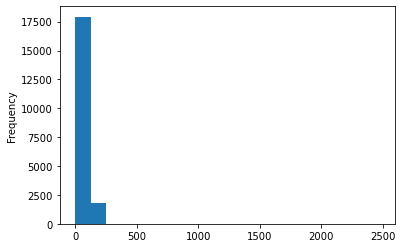

In [560]:
X_train.player_1_prev_min.plot.hist(bins = 20)

In [565]:
X_train.columns

Index(['tourney_name', 'surface', 'tourney_level', 'round', 'player_1_age',
       'player_2_age', 'player_1_hand', 'player_2_hand', 'player_1_ioc',
       'player_2_ioc', 'player_1_rank', 'player_2_rank', 'player_1_h2h',
       'player_2_h2h', 'player_1_recent_form', 'player_2_recent_form',
       'player_1_prev_min', 'player_2_prev_min'],
      dtype='object')

In [561]:
from sklearn.preprocessing import LabelEncoder

In [596]:
lencoder = LabelEncoder()

def numer_label(DF):
    '''
    Assign numeric labels to values in non-numeric columns
    to prepare data for gradient boosting regressor.
    '''
    categ_cols = ['tourney_name', 'surface', 'tourney_level',
                  'round', 'player_1_hand', 'player_2_hand',
                  'player_1_ioc', 'player_2_ioc']
    
    for name in categ_cols:
        DF[name] = lencoder.fit_transform(DF[name])
    return DF

X_train_gb = numer_label(X_train)
X_test_gb = numer_label(X_test)

<ipython-input-596-952370e23535>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF[name] = lencoder.fit_transform(DF[name])


In [567]:
gbc = GradientBoostingClassifier()

In [585]:
gs_params = {'max_features': [2,5,8],
             'max_depth': [3,4,5],
             'n_estimators': [500, 1000, 1500, 2000],
             'learning_rate': np.linspace(.01,1,6)}

gs = GridSearchCV(gbc, gs_params, cv = 5)

In [589]:
y_train

17987    player_1
13300    player_2
8377     player_2
23123    player_1
4678     player_1
           ...   
21575    player_1
5390     player_2
860      player_1
15795    player_1
23654    player_2
Name: target, Length: 19709, dtype: object

In [593]:
y_train_gb = (y_train == 'player_1').astype('int')
y_test_gb = (y_test == 'player_1').astype('int')

In [598]:
gs.fit(X_train_gb, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([0.01 , 0.208, 0.406, 0.604, 0.802, 1.   ]),
                         'max_depth': [3, 4, 5], 'max_features': [2, 5, 8],
                         'n_estimators': [500, 1000, 1500, 2000]})

In [597]:
X_train_gb

,tourney_name,surface,tourney_level,round,player_1_age,player_2_age,player_1_hand,player_2_hand,player_1_ioc,player_2_ioc,player_1_rank,player_2_rank,player_1_h2h,player_2_h2h,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
17987,779,3,6,6,23.808350,27.334702,1,1,25,61,21.0,54.0,0.0,0.0,0.697564,0.499660,0.00000,0.000000
13300,708,3,4,8,26.683094,21.875428,1,1,67,13,37.0,47.0,0.0,1.0,0.599781,0.762364,114.00000,68.000000
8377,30,3,6,4,20.002738,23.605749,1,1,28,19,50.0,11.0,0.0,1.0,0.593239,0.696825,127.29803,101.600299
23123,758,1,3,3,21.045859,26.045175,1,1,3,32,132.0,148.0,0.0,0.0,0.097674,0.297709,0.00000,0.000000
4678,782,3,3,3,24.607803,28.947296,0,1,28,26,6.0,81.0,1.0,0.0,0.698707,0.184945,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,736,3,6,5,21.440110,29.377139,1,1,63,76,14.0,26.0,1.0,2.0,0.489284,0.698845,0.00000,0.000000
5390,5,3,3,3,21.607118,23.485284,1,1,3,67,117.0,120.0,0.0,0.0,0.197220,0.190232,0.00000,0.000000
860,730,1,4,5,23.931554,20.991102,1,1,37,61,43.0,101.0,1.0,0.0,0.499468,0.295290,0.00000,0.000000
15795,725,3,4,5,28.101300,26.250513,1,1,22,28,12.0,130.0,2.0,0.0,0.489511,0.162318,0.00000,0.000000


In [599]:
gs

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([0.01 , 0.208, 0.406, 0.604, 0.802, 1.   ]),
                         'max_depth': [3, 4, 5], 'max_features': [2, 5, 8],
                         'n_estimators': [500, 1000, 1500, 2000]})

In [601]:
gs_best = gs.best_estimator_

In [602]:
gs_best.score(X_train_gb, y_train)

0.6898371302450657

In [603]:
gs_best.score(X_test_gb, y_test)

0.6497564935064936

In [604]:
gs_best

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features=8,
                           n_estimators=500)

In [623]:
gbc = GradientBoostingClassifier(learning_rate = .01, subsample = 1.0,
                                 max_depth = 8, max_features = 10,
                                 n_estimators = 500)

In [624]:
gbc.fit(X_train_gb, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features=10,
                           n_estimators=500)

In [625]:
gbc.score(X_train_gb, y_train)

0.8024760261809326

In [626]:
gbc.score(X_test_gb, y_test)

0.6515827922077922

In [629]:
sorted(list(zip(X_train_gb.columns, gbc.feature_importances_)), key = lambda x: -x[1])

[('player_2_rank', 0.19123906683553493),
 ('player_1_rank', 0.18757872992783378),
 ('player_2_recent_form', 0.1170485478579105),
 ('player_1_recent_form', 0.10051049396140015),
 ('player_1_age', 0.07305669568286378),
 ('player_2_age', 0.0692850752070046),
 ('tourney_name', 0.04847023944395274),
 ('player_1_ioc', 0.03604245791536005),
 ('player_2_ioc', 0.03595948456239761),
 ('player_2_prev_min', 0.0338319065015486),
 ('player_1_prev_min', 0.030425357184137018),
 ('round', 0.01608984384806925),
 ('player_2_h2h', 0.015405728015287836),
 ('player_1_h2h', 0.014701744504006959),
 ('tourney_level', 0.014151185535838379),
 ('surface', 0.00796636765251438),
 ('player_1_hand', 0.004645675018917004),
 ('player_2_hand', 0.0035914003454225528)]

246      Fed Cup G1 RRA: CHN vs UZB
247      Fed Cup G1 RRA: THA vs CHN
248      Fed Cup G1 RRA: CHN vs IND
249      Fed Cup G1 RRA: THA vs UZB
250      Fed Cup G1 RRA: THA vs UZB
                    ...            
22810    Fed Cup WG2 R1: SVK vs BRA
24537      Fed Cup WG F: FRA vs AUS
24538      Fed Cup WG F: FRA vs AUS
24539      Fed Cup WG F: FRA vs AUS
24540      Fed Cup WG F: FRA vs AUS
Name: tourney_name, Length: 1621, dtype: object

In [653]:
matches4[matches4['tourney_name'].apply(lambda x: x.startswith('Fed Cup WG '))][['player_1', 'player_2']]

,player_1,player_2
333,Francesca Schiavone,Jarmila Gajdosova
334,Flavia Pennetta,Samantha Stosur
335,Francesca Schiavone,Samantha Stosur
336,Flavia Pennetta,Jarmila Gajdosova
337,Alize Cornet,Svetlana Kuznetsova
...,...,...
22797,Sofia Kenin,Timea Bacsinszky
24537,Ajla Tomljanovic,Kristina Mladenovic
24538,Ashleigh Barty,Caroline Garcia
24539,Ashleigh Barty,Kristina Mladenovic


In [659]:
matches4[matches4['tourney_name'].apply(lambda x: x.startswith('Fed Cup WG '))]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
333,2011-D001,Fed Cup WG R1: AUS vs ITA,Hard,4,D,2011-02-05,1,6-7 6-3 6-3,3,RR,...,31,0.0,0.0,0.0,0.0,player_2,0.599432,0.699456,0.000000,0.000000
334,2011-D001,Fed Cup WG R1: AUS vs ITA,Hard,4,D,2011-02-05,2,7-6 6-7 6-4,3,RR,...,36,0.0,0.0,2.0,0.0,player_1,0.700000,0.593964,0.000000,0.000000
335,2011-D001,Fed Cup WG R1: AUS vs ITA,Hard,4,D,2011-02-05,3,7-6 3-6 7-5,3,RR,...,34,31.0,36.0,1.0,1.0,player_1,0.599733,0.477929,80.776204,68.915878
336,2011-D001,Fed Cup WG R1: AUS vs ITA,Hard,4,D,2011-02-05,4,6-3 6-2,3,RR,...,17,36.0,31.0,0.0,0.0,player_1,0.795687,0.792783,68.915878,80.776204
337,2011-D002,Fed Cup WG R1: RUS vs FRA,Hard,4,D,2011-02-05,1,3-6 6-3 6-4,3,RR,...,28,0.0,0.0,0.0,0.0,player_1,0.499200,0.600000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22797,2019-W-FC-2019-WG-PO-USA-SUI-01,Fed Cup WG R1: USA vs SUI,Hard,4,D,2019-04-20,4,6-3 7-6,3,RR,...,22,0.0,19.0,0.0,0.0,player_1,0.497564,0.496709,0.000000,95.000000
24537,2019-W-FC-2019-WG-M-FRA-AUS-01,Fed Cup WG F: FRA vs AUS,Hard,4,D,2019-11-09,1,6-1 6-1,3,RR,...,14,0.0,0.0,2.0,0.0,player_2,0.396551,0.596904,0.000000,0.000000
24538,2019-W-FC-2019-WG-M-FRA-AUS-01,Fed Cup WG F: FRA vs AUS,Hard,4,D,2019-11-09,2,6-0 6-0,3,RR,...,12,0.0,0.0,2.0,1.0,player_1,0.799719,0.271755,0.000000,0.000000
24539,2019-W-FC-2019-WG-M-FRA-AUS-01,Fed Cup WG F: FRA vs AUS,Hard,4,D,2019-11-09,3,2-6 6-4 7-6,3,RR,...,31,12.0,14.0,1.0,1.0,player_2,0.799654,0.686756,56.000000,72.000000


In [660]:
matches4[matches4['tourney_level'] == 'D']

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
246,2011-D041,Fed Cup G1 RRA: CHN vs UZB,Hard,4,D,2011-01-31,2,4-6 6-1 6-1,3,RR,...,24,0.0,0.0,0.0,0.0,player_2,0.000000,0.067630,0.0,0.0
247,2011-D042,Fed Cup G1 RRA: THA vs CHN,Hard,4,D,2011-01-31,2,6-3 4-6 6-1,3,RR,...,26,0.0,0.0,0.0,0.0,player_2,0.000000,0.094639,0.0,0.0
248,2011-D043,Fed Cup G1 RRA: CHN vs IND,Hard,4,D,2011-01-31,2,6-1 0-6 6-4,3,RR,...,23,0.0,0.0,0.0,0.0,player_1,0.000000,0.397674,0.0,0.0
249,2011-D044,Fed Cup G1 RRA: THA vs UZB,Hard,4,D,2011-01-31,1,6-3 7-5,3,RR,...,21,0.0,0.0,0.0,0.0,player_2,0.000000,0.067630,0.0,0.0
250,2011-D044,Fed Cup G1 RRA: THA vs UZB,Hard,4,D,2011-01-31,2,6-3 6-2,3,RR,...,17,0.0,0.0,0.0,0.0,player_2,0.143325,0.190232,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22810,2019-W-FC-2019-WG2-PO-SVK-BRA-01,Fed Cup WG2 R1: SVK vs BRA,Clay,4,D,2019-04-20,3,7-6 6-0,3,RR,...,19,18.0,14.0,0.0,0.0,player_2,0.585675,0.387481,89.0,66.0
24537,2019-W-FC-2019-WG-M-FRA-AUS-01,Fed Cup WG F: FRA vs AUS,Hard,4,D,2019-11-09,1,6-1 6-1,3,RR,...,14,0.0,0.0,2.0,0.0,player_2,0.396551,0.596904,0.0,0.0
24538,2019-W-FC-2019-WG-M-FRA-AUS-01,Fed Cup WG F: FRA vs AUS,Hard,4,D,2019-11-09,2,6-0 6-0,3,RR,...,12,0.0,0.0,2.0,1.0,player_1,0.799719,0.271755,0.0,0.0
24539,2019-W-FC-2019-WG-M-FRA-AUS-01,Fed Cup WG F: FRA vs AUS,Hard,4,D,2019-11-09,3,2-6 6-4 7-6,3,RR,...,31,12.0,14.0,1.0,1.0,player_2,0.799654,0.686756,56.0,72.0


In [667]:
# Remove challenger and low-level fed cup matches.
# Too many players in these tournaments do not appear regularly in tour matches

mask = ((matches4['tourney_level'] != 'D') | matches4['tourney_name'].apply(lambda x: x.startswith('Fed Cup WG '))) & (matches4['tourney_level'] != 'C')

In [668]:
matches5 = matches4[mask]

In [669]:
matches5.groupby('tourney_level')[['player_1_recent_form', 'player_1_h2h', 'player_1_prev_min', 'player_1_rank']].mean()

,player_1_recent_form,player_1_h2h,player_1_prev_min,player_1_rank
tourney_level,,,,
D,0.506115,0.513648,36.902173,54.002481
F,0.647784,1.310811,64.256322,11.256757
G,0.508434,0.457499,46.749001,61.379617
I,0.410064,0.256944,45.713720,99.775403
O,0.584399,0.622951,45.599101,38.622951
P,0.538034,0.665138,46.504852,48.152788
PM,0.545067,0.640753,45.745109,48.081424
W,0.738153,2.333333,75.478286,6.000000


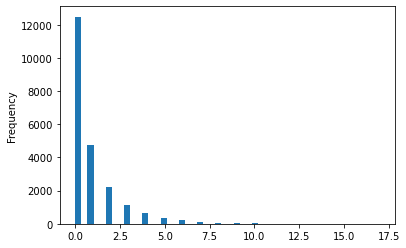

In [674]:
(matches5['player_1_h2h']+matches5['player_2_h2h']).plot.hist(bins = 50)

In [673]:
matches5

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,total_games,player_1_prev_games,player_2_prev_games,player_1_h2h,player_2_h2h,target,player_1_recent_form,player_2_recent_form,player_1_prev_min,player_2_prev_min
0,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,1,7-6 6-1,3,R32,...,20,0.0,0.0,0.0,0.0,player_2,0.389762,0.337979,0.0,0.0
1,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,2,6-2 7-5,3,R32,...,20,0.0,0.0,1.0,0.0,player_2,0.280270,0.599916,0.0,0.0
2,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,3,6-4 6-3,3,R32,...,19,0.0,0.0,0.0,0.0,player_2,0.398982,0.097674,0.0,0.0
3,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,4,6-3 6-0,3,R32,...,15,0.0,0.0,0.0,0.0,player_2,0.496934,0.599456,0.0,0.0
4,2011-W-INT-AUS-01A-2011,Brisbane,Hard,32,I,2011-01-03,5,6-1 6-2,3,R32,...,15,0.0,0.0,0.0,0.0,player_1,0.599114,0.287195,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24632,2019-1072,Limoges,Hard,32,I,2019-12-16,295,6-3 7-5,3,QF,...,21,28.0,25.0,0.0,0.0,player_1,0.399340,0.387175,111.0,124.0
24633,2019-1072,Limoges,Hard,32,I,2019-12-16,297,6-4 6-2,3,QF,...,18,31.0,19.0,0.0,0.0,player_2,0.396825,0.691470,130.0,68.0
24634,2019-1072,Limoges,Hard,32,I,2019-12-16,298,2-6 6-2 6-2,3,SF,...,24,21.0,20.0,0.0,0.0,player_1,0.398707,0.497961,95.0,86.0
24635,2019-1072,Limoges,Hard,32,I,2019-12-16,299,7-6 6-2,3,SF,...,21,18.0,22.0,0.0,0.0,player_1,0.777281,0.597674,71.0,83.0
